In [5]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import stepwise_regression

In [6]:
from Filter_and_Grid_Search import *
import os
from sklearn.externals import joblib as skjoblib
import joblib
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from importlib import reload
import Filter_and_Grid_Search
Filter_and_Grid_Search = reload(Filter_and_Grid_Search)

In [7]:
import sys

import gc
import itertools
import math
import os
import random
import re
from datetime import datetime
from importlib import reload

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pydotplus
import seaborn as sns
import shap

from IPython.display import Image
from lightgbm import LGBMClassifier
from scipy.stats import norm
from seaborn import heatmap
from sklearn import metrics, tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm


from pipeline_utils import (append_for_deletion, 
                            remove_from_deletion, 
                            funnel_func, 
                            mu,
                            roc_lift_gain, 
                            time_ranges_plot,
                            binary_hists, 
                            bootscores_concat,
                            by_month, 
                            check_nans, 
                            count_data, 
                            display_nicely,
                            drop_unnamed, 
                            get_pretty_dates, 
                            model_stats,
                            show_descriptions,
                            show_sources)

from ml_pipeline import (attributes_list_new, 
                         bootstrap,
                         br_correction, 
                         by_month_gini,
                         calculate_vif,
                         check_attribute_list_cases,
                         data_preprocessing,
                         data_preprocessing_test,
                         data_preprocessing_train,
                         feature_importance,
                         find_doubles_corr, 
                         find_meta_params,
                         find_meta_params_optuna,
                         find_ouliers_iqr, 
                         for_splines,
                         get_stats, 
                         get_stats_by_month,
                         get_stats_on_target,
                         get_stats_on_target_by_month, 
                         linear_calib_use_model_data,
                         lr_test_all_features, 
                         make_standard,
                         plot_meta_2d, 
                         receive_correlations,
                         simple_b_score_crm, 
                         stable_unstable,
                         stable_unstable_by_month_divide,
                         statistics_with_target,
                         stratified_split,
                         train_model_receive_stats,
                         turn_variables_with_values,
                         two_forests, 
                         union_datas)

## Data upload

In [9]:
PATH_ROOT = 'D:/Share/dkotereva/APP_PD_GP/' 
PATH = PATH_ROOT  
print(PATH)

D:/Share/dkotereva/APP_PD_GP/


In [10]:
#datasets_file = 'data_Branch.zip' 
train_data = 'app_pd_gp_train.zip' 
test_data = 'app_pd_gp_test.zip' 
oot_data = 'app_pd_gp_oot.zip' 

black_list = 'black_list.xlsx' 
black_field_var = 'Переменная' 
filename_dump = 'GP.data' 

task = 'binary' 
missing_strings = 'MISSING' 
p_value = 0.05 

recommended_list = False 
target_dict = {'bad': 1, 'good': 0} 

In [11]:
target = 'BAD_90P' 
index_month = 'date_report' 
list_of_vars_for_strat = ['date_report'] 
sort_by_var = 'cif_id' 

necessary_fields = [target, index_month, sort_by_var] 
necessary_fields_upper = [target.upper(), index_month.upper(), sort_by_var.upper()] 


COL_SYS = ['INITIATED_DT', 'ROBOT_DAY', 'DEL_FLAG', 'INITIATED_DT_OUT',
'CALL_OUT_DAY', 'SD', 'SMS_DAY', 'MONTHCALLMINUS2',
'XSBASEDT_24M', 'XSBASEDT_12M', 'CALLDT', 'CALCDT_1M',
'CALCDT_3M', 'CALCDT_6M', 'CALCDT_12M', 'CALCDT_24M',
'CLIENT_NUMBER_TEXT', 'CIF_ID_TEXT', 'CLIENT_NUMBER',
'DATE_REPORT_O', 'DATE_REPORT_B', 'SUPERID', 'SUPERID_OPEN',
'SUPERID_AP', 'SUPERID_BUREAU', 'BUREAU_DT', 'UNNAMED: 0', index_month.upper()+'_GROSS', 'ACTIVE_IND']
COL_TRG = target.upper()
hyper_disbalance= False

In [12]:
list_of_vars_for_strat_upper = [c.upper() for c in list_of_vars_for_strat]
sort_by_var_upper = sort_by_var.upper()

In [13]:
target = target.upper()

In [10]:
changes = pd.read_csv(PATH+'SandBox/csv/changes.csv', sep = '\t')

In [11]:
changes.head()

,Unnamed: 0,new variable,genuine variable,rule,values
0,0,GENDER_1.0,GENDER,_1.0,1.0
1,1,GENDER_2.0,GENDER,_2.0,2.0
2,2,DLQ_WASDELAY_0.0,DLQ_WASDELAY,_0.0,0.0
3,3,DLQ_WASDELAY_1.0,DLQ_WASDELAY,_1.0,1.0
4,4,R_CNT_ALL_IL_bin,R_CNT_ALL_IL,_bin,NaN


In [12]:
file_name = PATH + 'Selection/excel/11. f_target_s_aft_bin.xlsx'
stay7 = pd.read_excel(file_name, index = False)

In [13]:
def_2 = stay7['feature'].to_list()

In [15]:
new_features_list = []
cols = ['new variable', 'genuine variable', 'rule', 'values']

for i in def_2:
    if i in list(changes['new variable']):
        change = changes[changes['new variable'] == i]
        new_features_list.append([list(change['new variable'])[0], list(change['genuine variable'])[0], 
                                  list(change['rule'])[0], list(change['values'])[0]])
    else:
        new_features_list.append([i, i, 'Missing', np.nan])
        
for i in necessary_fields_upper:
    if i not in def_2:
        new_features_list.append([i, i, 'Missing', np.nan])
    
new_features_data = pd.DataFrame.from_records(new_features_list, columns = cols)

In [16]:
new_features_data.shape

(222, 4)

In [17]:
new_features_data.to_csv(PATH + 'SandBox/csv/selected_features_forest_definition.csv', sep = '&')

# Experiment 2

In [326]:
all_columns = pd.read_csv(PATH + 'SandBox/csv/selected_features_forest_definition.csv', sep = '&')

In [327]:
data1 = pd.read_csv(PATH + 'Data Sets/' +  train_data, sep = '\t', encoding = 'cp1251')
data1.columns = [col.upper() for col in data1.columns]

In [328]:
data = turn_variables_with_values(data1, all_columns)

In [329]:
columns = data.columns

In [330]:
changes = pd.read_csv(PATH + 'SandBox/csv/changes.csv', sep = '\t')

In [331]:
categorial_columns = []
for i in columns:
    if len(re.findall('_bin', i)) > 0:
        categorial_columns.append(i)

In [332]:
necessary_fields_upper

['BAD_90P', 'DATE_REPORT', 'CIF_ID']

In [333]:
gc.collect()

2898

## 2.1 Gini Scheme 

In [334]:
columns = list(data.columns)

In [335]:
file_name = PATH + 'Selection/excel/12. COR_NUM_binned.xlsx'
correlation_num1 = pd.read_excel(file_name)
file_name = PATH + 'Selection/excel/12. COR_CAT_binned.xlsx'
correlation_cat1 = pd.read_excel(file_name)
definition_2 = pd.read_csv(PATH + 'SandBox/csv/definition_2.csv')

In [336]:
correlation_cat1.set_index('Unnamed: 0', inplace = True)
correlation_num1.set_index('Unnamed: 0', inplace = True)

In [337]:
correlation_num1.head()

,COUNTPREVCONTR_0PL,FINALAPPROVE_FLAG_2D,R_CNT_ALL_IL,R_CNT_OPEN_GP,R_CNT_OPEN_IL,R_CNT_OPEN_CC,R_AMT_OPEN_IL,R_AMT_OPEN_CC,R_AMT_CLOS_IL,R_DLQ_SUM_30PL,...,OW_AV_DEBT_24M,INQ_MORTGAGE,INQ_CC,INQ_MORT_TTL,INQ_CC_TTL,INQ_TTL_LAST7,BURAPPRRT_L3M,AMTSEQACTV_SUM,CNTRACTVNOWN_CNT,LIMIT01_SUM
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
COUNTPREVCONTR_0PL,1.000000,0.778406,0.360325,0.458044,0.067920,0.462343,0.037179,0.313585,0.275256,0.084957,...,0.051155,-0.011665,0.074904,-0.009006,0.055388,-0.162621,0.018086,-0.007344,-0.003274,-0.003657
FINALAPPROVE_FLAG_2D,0.778406,1.000000,0.217642,0.380531,-0.031627,0.361987,0.009760,0.192429,0.204321,0.049007,...,0.072650,0.003302,0.133619,0.002544,0.104152,-0.106973,-0.001123,0.000256,0.047137,0.004767
R_CNT_ALL_IL,0.360325,0.217642,1.000000,-0.158876,0.342720,-0.066613,0.126854,-0.037425,0.442696,0.088934,...,-0.022112,0.003620,-0.050084,0.003105,-0.037790,0.013831,0.018957,0.010285,-0.013187,-0.001338
R_CNT_OPEN_GP,0.458044,0.380531,-0.158876,1.000000,-0.165679,0.387127,-0.038811,0.218372,0.043266,-0.003030,...,0.028121,-0.036887,0.030334,-0.031183,0.013625,-0.164297,-0.011375,-0.023719,-0.053885,-0.017816
R_CNT_OPEN_IL,0.067920,-0.031627,0.342720,-0.165679,1.000000,-0.087653,0.318817,-0.054988,0.005543,-0.019738,...,-0.053000,-0.022284,-0.040107,-0.017054,-0.026936,-0.083356,0.037112,-0.003219,-0.088758,-0.010027


In [338]:
result_tab_cat1, non_doubles_cat1, col_doubles_cat1, double_dic_cat1 = find_doubles_corr(data, columns, 
                                  correlation_cat1, definition = definition_2, lvl = 0.70, light_unstable = None)
result_tab_num1, non_doubles_num1, col_doubles_num1, double_dic_num1 = find_doubles_corr(data, columns, 
                                  correlation_num1, definition = definition_2, lvl = 0.70, light_unstable = None)

Порог = 0.7 Осталось фичей = 25 Коррелир.фичей = 53
Порог = 0.7 Осталось фичей = 88 Коррелир.фичей = 52


In [339]:
result_tab_cat1, non_doubles_cat1, col_doubles_cat1, double_dic_cat1 = find_doubles_corr(data, columns, 
                                  correlation_cat1, definition = definition_2, lvl = 0.50, light_unstable = None)
result_tab_num1, non_doubles_num1, col_doubles_num1, double_dic_num1 = find_doubles_corr(data, columns, 
                                  correlation_num1, definition = definition_2, lvl = 0.50, light_unstable = None)

Порог = 0.5 Осталось фичей = 17 Коррелир.фичей = 61
Порог = 0.5 Осталось фичей = 52 Коррелир.фичей = 88


In [340]:
non_doubles1 = list(set(non_doubles_cat1 + non_doubles_num1))

In [341]:
len(non_doubles1)

69

In [342]:
COL_DEL1 = []

for i in data.columns:
    if i not in non_doubles1 + necessary_fields_upper:
        COL_DEL1.append(i)

In [343]:
data.drop(COL_DEL1, axis = 1, inplace = True)

In [344]:
for i in necessary_fields_upper:
    if i not in list(data.columns):
        print(i)

In [345]:
data_prepr, scale = data_preprocessing_train(data, COL_TRG, 
                                technical_values = [COL_SYS+necessary_fields_upper], 
                                drop_technical = False,
                                yeo_johnson = False, 
                                attribute_list = None, 
                                var_col = None,
                                scale = 'mean', 
                                median = 'median',
                                high_outlier = 99, 
                                low_outlier = 1, 
                                cols_outlier = None)

data = data_preprocessing_train(data, COL_TRG, 
                                technical_values = [COL_SYS+necessary_fields_upper], 
                                drop_technical = False,
                                yeo_johnson = False, 
                                attribute_list = None, 
                                var_col = None,
                                scale = False, 
                                median = 'median',
                                high_outlier = None, 
                                low_outlier = None, 
                                cols_outlier = None)


In [346]:
if 'Unnamed: 0' in data_prepr.columns.to_list():
    data_prepr.drop('Unnamed: 0', axis = 1, inplace = True)
    
if 'Unnamed: 0.1' in data_prepr.columns.to_list():
    data_prepr.drop('Unnamed: 0.1', axis = 1, inplace = True)

In [347]:
data_prepr.head()

,CIF_ID,FINALAPPROVE_FLAG_2D,R_CNT_ALL_IL,R_CNT_OPEN_GP,R_CNT_OPEN_IL,R_CNT_OPEN_CC,R_AMT_OPEN_IL,R_AMT_CLOS_IL,R_DLQ_SUM_30PL,R_DLQ_WSTEV_MIN,...,TIME_SINCEL_90_bin,MICRO2ALL_03M_bin,LIMIT_24_MAX_bin,OPENLYEARCCSUM_bin,SINCELSTCLSDCC_bin,CLOSED24_SUM_bin,BURAPPRRT_L3M_bin,AMTSEQACTV_SUM_bin,LIMIT01_SUM_bin,BAD_90P
0,-0.023096,0.605588,0.024223,-0.562779,-0.466264,0.808351,-0.116134,-0.879727,-0.161159,-0.191623,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1
1,-0.385205,-0.424260,-1.341847,-0.562779,-0.466264,-0.493136,-0.116134,-0.187447,-0.161159,0.088510,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.519601,-1.110826,0.024223,-0.562779,-0.466264,-0.493136,-0.116134,-0.187447,-0.161159,-0.191623,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,0.109674,0.262305,1.390294,-0.562779,-0.466264,-0.493136,-0.116134,-0.257195,-0.161159,-0.191623,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1
4,0.392982,-0.424260,0.024223,-0.562779,1.864696,-0.493136,-0.110919,-0.187447,-0.161159,-0.191623,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0


In [348]:
data_prepr1 = data_prepr.drop(necessary_fields_upper, axis = 1)
y = data_prepr[target]

In [349]:
once_rows = sum(data[target])
second_rows = (len(data[target]) - sum(data[target]))
y_unique = sorted(data[target].unique())
all_rows = len(data[target])

once_rows_share = once_rows/all_rows
second_rows_share = second_rows/all_rows
second_rows_share/once_rows_share

if once_rows < second_rows:
    w_b = once_rows/second_rows
else:
    w_b = second_rows/once_rows

In [350]:
once_rows_share, second_rows_share

(0.0335510790382708, 0.9664489209617292)

In [351]:
w_b

0.03471583268454951

## Forward Pass

In [352]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
lr = LogisticRegression(class_weight = {0: w_b, 1:1}, max_iter = 300, C = 0.5, solver = 'liblinear', penalty = 'l2')


sfs1 = SFS(lr, 
           k_features= 'best', 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           n_jobs = 3,
           cv=2)

sfs1 = sfs1.fit(data_prepr1, y)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   39.5s
[Parallel(n_jobs=3)]: Done  69 out of  69 | elapsed:  1.3min finished

[2020-06-26 02:40:04] Features: 1/69 -- score: 0.588914750919704[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   49.9s
[Parallel(n_jobs=3)]: Done  68 out of  68 | elapsed:  1.5min finished

[2020-06-26 02:41:32] Features: 2/69 -- score: 0.6099611127264839[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   52.8s
[Parallel(n_jobs=3)]: Done  67 out of  67 | elapsed:  1.7min finished

[2020-06-26 02:43:16] Features: 3/69 -- score: 0.6280897434453807[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   51.9s
[Parallel(n_jobs=3)]: Done  66 out of  66 | elaps

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  8.4min
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:  9.1min finished

[2020-06-26 04:55:41] Features: 30/69 -- score: 0.7036864724426033[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  39 out of  39 | elapsed:  9.6min finished

[2020-06-26 05:05:15] Features: 31/69 -- score: 0.7040898066112057[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  38 out of  38 | elapsed:  9.4min finished

[2020-06-26 05:14:39] Features: 32/69 -- score: 0.7045223167474153[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  37 out of  37 | elapsed:  9.5min finished

[2020-06-26 05:24:09] Features: 33/69 -- score: 0.7048947165963887[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  8.3min finished

[2020-06-26 05:32:28

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   51.8s finished

[2020-06-26 08:12:33] Features: 67/69 -- score: 0.7062662949896421[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   51.6s finished

[2020-06-26 08:13:25] Features: 68/69 -- score: 0.7060682373811109[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.1s finished

[2020-06-26 08:14:16] Features: 69/69 -- score: 0.7058479797528279

In [354]:
forward_col = list(sfs1.k_feature_names_)
len(forward_col)

54

In [355]:
vif_del = []

In [356]:
vif = calculate_vif(data_prepr[forward_col])
vif.sort_values(by = 'VIF', ascending = False, inplace = True)

26.06.2020 08:14:17 0 FINALAPPROVE_FLAG_2D
26.06.2020 08:18:13 10 UNUSEDLIMCCMAX
26.06.2020 08:21:26 20 OW_PMT_DYN
26.06.2020 08:24:14 30 OW_MIN_SHARE
26.06.2020 08:27:17 40 GENDER_2.0
26.06.2020 08:30:37 50 SINCELSTCLSDCC_bin


In [357]:
vif.head()

,Features,VIF
42,R_AMT_OPEN_IL_bin,20.739772
2,R_CNT_OPEN_IL,17.747010
45,DLQ_WRSTARR07E_bin,15.230825
48,LIMIT_24_MAX_bin,11.585056
44,LIMITCC_MAX_bin,9.629952


In [358]:
vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()
while vif['VIF'][0] > 10:
    print(vif.head(5))
    c = vif.Features[0]
    vif_del.append(c)
    print('Delete ', c)
    vif = calculate_vif(data_prepr[[c for c in forward_col if c not in vif_del]])
    vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()

   index            Features        VIF
0     42   R_AMT_OPEN_IL_bin  20.739772
1      2       R_CNT_OPEN_IL  17.747010
2     45  DLQ_WRSTARR07E_bin  15.230825
3     48    LIMIT_24_MAX_bin  11.585056
4     44     LIMITCC_MAX_bin   9.629952
Delete  R_AMT_OPEN_IL_bin
26.06.2020 08:32:00 0 FINALAPPROVE_FLAG_2D
26.06.2020 08:35:21 10 UNUSEDLIMCCMAX
26.06.2020 08:38:22 20 OW_PMT_DYN
26.06.2020 08:41:28 30 OW_MIN_SHARE
26.06.2020 08:45:30 40 GENDER_2.0
26.06.2020 08:50:22 50 BURAPPRRT_L3M_bin
   index            Features        VIF
0     44  DLQ_WRSTARR07E_bin  15.099681
1     47    LIMIT_24_MAX_bin  11.393599
2     43     LIMITCC_MAX_bin   9.595885
3     45  DLQ_WRSTARR25E_bin   7.635699
4     28      DLQ_OVDUESHARE   6.653349
Delete  DLQ_WRSTARR07E_bin
26.06.2020 08:52:13 0 FINALAPPROVE_FLAG_2D
26.06.2020 08:58:26 10 UNUSEDLIMCCMAX
26.06.2020 09:07:08 20 OW_PMT_DYN
26.06.2020 09:11:04 30 OW_MIN_SHARE
26.06.2020 09:19:49 40 GENDER_2.0
26.06.2020 09:24:13 50 AMTSEQACTV_SUM_bin


In [359]:
vif.head()

,index,Features,VIF
0,46,LIMIT_24_MAX_bin,9.368621
1,43,LIMITCC_MAX_bin,9.309376
2,44,DLQ_WRSTARR25E_bin,6.924207
3,28,DLQ_OVDUESHARE,6.650839
4,31,DLQ_PD2AMTOUTS,6.241437


In [360]:
len(vif_del)

2

In [361]:
new_features_list = []
cols = ['new variable', 'genuine variable', 'rule', 'values']

for i in forward_col:
    if i in list(changes['new variable']):
        change = changes[changes['new variable'] == i]
        new_features_list.append([list(change['new variable'])[0], list(change['genuine variable'])[0], 
                                  list(change['rule'])[0], list(change['values'])[0]])
    else:
        new_features_list.append([i, i, 'Missing', np.nan])
        
for i in necessary_fields_upper:
    new_features_list.append([i, i, 'Missing', np.nan])
    
new_features_data = pd.DataFrame.from_records(new_features_list, columns = cols)
new_features_data_no_vif = new_features_data[~new_features_data['new variable'].isin(vif_del)]
new_features_data_no_vif_no_sys = new_features_data_no_vif[~new_features_data_no_vif['new variable'].isin(necessary_fields_upper)]

In [362]:
new_features_data.shape, new_features_data_no_vif.shape

((57, 4), (55, 4))

In [363]:
new_features_data.to_csv(PATH + 'SandBox/csv/selected_features_forward.csv', sep = '&')
new_features_data_no_vif.to_csv(PATH + 'SandBox/csv/selected_features_vif_forward.csv', sep = '&')
new_features_data_no_vif_no_sys.to_csv(PATH + 'SandBox/csv/selected_features_vif_no_sys_forward.csv', sep = '&')

In [364]:
new_features_data = pd.read_csv(PATH + 'SandBox/csv/selected_features_forward.csv', sep = '&')
new_features_data_no_vif= pd.read_csv(PATH + 'SandBox/csv/selected_features_vif_forward.csv', sep = '&')
new_features_data_no_vif_no_sys= pd.read_csv(PATH + 'SandBox/csv/selected_features_vif_no_sys_forward.csv', sep = '&')

In [365]:
modeling = 'forward'

In [366]:
#selected_features = pd.read_csv(PATH + 'SandBox/csv/selected_features_forest_vif.csv', sep = '&')
selected_features = new_features_data_no_vif
sel_c = selected_features['genuine variable'].to_list()

In [367]:
gc.collect()

1532

In [368]:
train = pd.read_csv(PATH + 'Data Sets/' +  train_data, sep = '\t', encoding = 'cp1251')
train.columns = [col.upper() for col in train.columns]

test = pd.read_csv(PATH + 'Data Sets/' +  test_data, sep = '\t', encoding = 'cp1251')
test.columns = [col.upper() for col in test.columns]

oot = pd.read_csv(PATH + 'Data Sets/' +  oot_data, sep = '\t', encoding = 'cp1251')
oot.columns = [col.upper() for col in oot.columns]

In [369]:
train = turn_variables_with_values(train, selected_features)
test = turn_variables_with_values(test, selected_features)
oot = turn_variables_with_values(oot, selected_features)

In [370]:
target = target.upper()

In [371]:
y_train = train[target]
y_test = test[target]
y_oot = oot[target]

train.drop(target, axis = 1, inplace = True)
test.drop(target, axis = 1, inplace = True)
oot.drop(target, axis = 1, inplace = True)

In [372]:
train.head()

,FINALAPPROVE_FLAG_2D,R_CNT_ALL_IL,R_CNT_OPEN_IL,R_AMT_OPEN_IL,R_AMT_CLOS_IL,R_DLQ_WSTEV_MIN,AGE,CNTR_AL_CNT,CNTR_MORT_CNT,LIMIT_MIN,...,DLQ_WRSTARR25E_bin,TIME_SINCEL_90_bin,LIMIT_24_MAX_bin,OPENLYEARCCSUM_bin,SINCELSTCLSDCC_bin,BURAPPRRT_L3M_bin,AMTSEQACTV_SUM_bin,LIMIT01_SUM_bin,DATE_REPORT,CIF_ID
0,5.0,1.0,0.0,NaN,12159.84,0.0,44.0,0.0,0.0,2000.0,...,0,0,1,1,0,0,0,0,201509,1017553504
1,2.0,0.0,0.0,NaN,NaN,1.0,34.0,0.0,0.0,3733.0,...,1,1,1,0,0,0,0,0,201509,1014239655
2,0.0,NaN,NaN,NaN,NaN,NaN,25.0,0.0,0.0,54000.0,...,1,0,1,0,0,0,0,0,201509,1022520005
3,4.0,2.0,0.0,NaN,22841.52,0.0,38.0,0.0,0.0,5000.0,...,0,0,1,1,0,1,0,0,201509,1018768545
4,2.0,1.0,1.0,31985.52,NaN,0.0,25.0,0.0,0.0,3000.0,...,0,0,1,1,0,1,0,0,201509,1021361246


In [373]:
list_of_columns = selected_features['new variable'].to_list()
list_of_columns_no_sys = list_of_columns.copy()
for i in necessary_fields_upper:
    if i in list_of_columns_no_sys:
        list_of_columns_no_sys.remove(i)

In [374]:
len(list_of_columns_no_sys)

52

In [375]:
attribute_list_model = attributes_list_new(train, list_of_columns_no_sys, [0.01, 0.5, 1, 2, 5, 95, 97, 
                                                                           98, 99, 99.5, 99.99])

[1.000e-04 5.000e-03 1.000e-02 2.000e-02 5.000e-02 9.500e-01 9.700e-01
 9.800e-01 9.900e-01 9.950e-01 9.999e-01]
Number of finished repetitions: 0 | time:  26.06.2020 09:26:26


In [376]:
attribute_list_model[attribute_list_model['99%'] == attribute_list_model['1%']]

,attribute,type_val,count_dist,count_miss,moda_val,count_value_moda,count_val,mean,stand_d_val,min_val,...,2%,5%,val_mediana,95%,97%,98%,99%,99.5%,99.99%,max_val


In [377]:
list_of_categories_sel = attribute_list_model.loc[(attribute_list_model['count_dist'] == 2), 'attribute'].to_list() 

In [378]:
categorials_data_fin = pd.read_csv(PATH + 'SandBox/csv/categories_fin.csv', sep = '&')

In [379]:
categorials_data_fin.head()

,Unnamed: 0,feature
0,0,LIMITCC_MAX_bin
1,1,R_AMT_OPEN_IL_bin
2,2,DLQ_WASDELAY_1.0
3,3,PMT_SUM_bin
4,4,CLOSED06_SUM_bin


In [380]:
for i in list_of_columns_no_sys:
    if i in categorials_data_fin['feature'].to_list():
        list_of_categories_sel.append(i)

In [381]:
list_of_categories_sel

['GENDER_2.0',
 'DLQ_WASDELAY_0.0',
 'R_DLQ_SUM_30PL_bin',
 'LIMITCC_MAX_bin',
 'DLQ_WRSTARR25E_bin',
 'TIME_SINCEL_90_bin',
 'LIMIT_24_MAX_bin',
 'OPENLYEARCCSUM_bin',
 'SINCELSTCLSDCC_bin',
 'BURAPPRRT_L3M_bin',
 'AMTSEQACTV_SUM_bin',
 'LIMIT01_SUM_bin',
 'GENDER_2.0',
 'DLQ_WASDELAY_0.0',
 'R_DLQ_SUM_30PL_bin',
 'LIMITCC_MAX_bin',
 'DLQ_WRSTARR25E_bin',
 'TIME_SINCEL_90_bin',
 'LIMIT_24_MAX_bin',
 'OPENLYEARCCSUM_bin',
 'SINCELSTCLSDCC_bin',
 'BURAPPRRT_L3M_bin',
 'AMTSEQACTV_SUM_bin',
 'LIMIT01_SUM_bin']

In [382]:
iqr_outliers = find_ouliers_iqr(train, necessary_fields_upper, mult = 1.5, check_percentile = 1)

In [383]:
once_rows = sum(y_train)
second_rows = (len(y_train) - sum(y_train))
y_unique = sorted(y_train.unique())
all_rows = len(y_train)

once_rows_share = once_rows/all_rows
second_rows_share = second_rows/all_rows
second_rows_share/once_rows_share

if once_rows < second_rows:
    w_b = once_rows/second_rows
else:
    w_b = second_rows/once_rows

In [384]:
once_rows_share, second_rows_share

(0.0335510790382708, 0.9664489209617292)

In [385]:
w_b

0.03471583268454951

In [393]:
C = [0.5]
CC  = [1]
w = np.multiply(CC, w_b)
print(C)
print(w_b)
print(w)

[0.5]
0.03471583268454951
[0.03471583]


In [394]:
from Filter_and_Grid_Search import simple_b_score_crm

In [395]:
help(simple_b_score_crm)

Help on function simple_b_score_crm in module Filter_and_Grid_Search:

simple_b_score_crm(_tn, _fp, _fn, _tp, m_s, k, c, pos_label=None, sample_weight=None)
    Функция в одну строчку, которая считает бизнес метрику по элементам confusion matrix



In [396]:
params_dictionary = {'C': C,
                     'weight_0': w,
                     'regularization': 'l2', 'random_state': 241, 
                    'solver': 'liblinear', 'max_iter':  [300]}
params_to_model = {'C': 'C', 'weight_0': 'class_weight', 'regularization':'penalty', 'random_state': 'random_state',
                  'solver': 'solver', 'max_iter': 'max_iter'}
pass_model = LogisticRegression

sort_by_var = sort_by_var.upper()
list_of_vars_for_strat = ['DATE_REPORT']
second_target = None
yeo_johnson = False
n_fold = 5
simple_b_score = simple_b_score_crm
business_dictionary = {'m_s': 15900, 'k': 47, 'c': 1}


In [397]:
high_outs = [99]
low_outs = [1]
params_preproc_grid = {'high_outlier': high_outs, 'low_outlier': low_outs}

In [398]:
combination_preproc = list(itertools.product(*params_preproc_grid.values()))

In [399]:
from Filter_and_Grid_Search import br_correction

Максимальный BR = 0.050715845668527056
Список срезов для выравнивания: [201509 201510 201511 201512 201601 201602 201603 201604 201605 201606
 201607 201608 201609 201610 201611 201612 201701 201702 201703 201704
 201705 201706 201707 201708 201709 201710 201711 201712 201801 201802
 201803 201804 201805 201806]
Максимальный BR = 0.05075240676698757


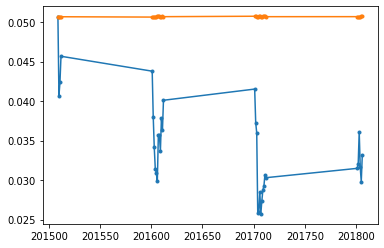

In [400]:
train = train.join(y_train)
train1 = br_correction(train, index_month.upper(), target, correct = True, random_state = 42, alpha = 0)

In [401]:
y_train = train1[target]
train1.drop(target, axis = 1, inplace = True)

In [402]:
attribute_list_model = attributes_list_new(train1, list_of_columns_no_sys, high_outs+low_outs)

[0.99 0.01]
Number of finished repetitions: 0 | time:  26.06.2020 09:26:53


In [403]:
len(C)*len(CC)

1

In [404]:
from Filter_and_Grid_Search import lr_test_one_simple, lr_test_all_features

In [405]:
new_meta_with_prepr = []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]
            
    non_outliers = attribute_list_model.loc[attribute_list_model[str(dicts['high_outlier'])+'%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
    cols_outliers = list_of_columns_no_sys.copy()
    
    for o in non_outliers:
        if o in cols_outliers:
            cols_outliers.remove(o)
                
    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta = find_meta_params(train1, y_train, 
                            params_dictionary, params_to_model, pass_model, 
                            sort_by_var, list_of_vars_for_strat, n_fold, second_target, yeo_johnson, 
                            attribute_list = None, var_col = None, categorial_list = list_of_categories_sel,
                            cols_outlier = cols_outliers,
                            need_business = False, draw = False, draw_by_approval_rate = False,
                            simple_b_score = None, business_dict = None,
                            business_dict_sec = None,
                            scale = 'mean', median = 'median',
                            high_outlier = dicts['high_outlier'], 
                            low_outlier = dicts['low_outlier'], check_percentile = 1,
                            random_state = 241, task = 'binary', k_logs = 10,
                            cut_non_out_9999 = True)
    i_meta['high_outlier'] = dicts['high_outlier']
    i_meta['low_outlier'] = dicts['low_outlier']
        
    new_meta_with_prepr.append(i_meta)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.5], 'weight_0': array([0.03471583]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 26.06.2020 09:34:18 0 -------------------- 
 Параметры: {'C': 0.5, 'class_weight': {0: 0.03471583268454951, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.11752558910978168 
 Среднее значение AUC = 0.7046584242309606


In [406]:
i_meta['weight'] = round(i_meta['weight_0'], 4)

In [407]:
i_meta.sort_values(by = 'AUC', ascending = False)[['AUC', 'AUC_std', 'weight_0', 'C', 'high_outlier', 'low_outlier', 'Pre']]

,AUC,AUC_std,weight_0,C,high_outlier,low_outlier,Pre
0,0.704658,0.004135,0.034716,0.5,99,1,0.072693


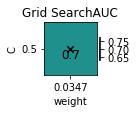

In [408]:
plot_meta_2d(meta = i_meta, first_dimention = 'C', second_dimention = 'weight', b_best = 'AUC')

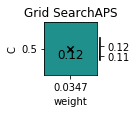

In [409]:
plot_meta_2d(meta = i_meta, first_dimention = 'C', second_dimention = 'weight', b_best = 'APS')

In [410]:
i_meta.to_csv(PATH +'Modeling_' + modeling + '/meta_file1.csv', sep='&')

In [411]:
i_meta = pd.read_csv(PATH +'Modeling_' + modeling + '/meta_file1.csv', sep='&')

In [412]:
list_of_columns = list(train1.columns)
list_of_columns_no_sys = list_of_columns.copy()
for i in necessary_fields_upper:
    if i in list_of_columns_no_sys:
        list_of_columns_no_sys.remove(i)

In [413]:
attribute_list_model = attributes_list_new(train1, list_of_columns_no_sys, [1, 98, 99, 99.99])

[0.01   0.98   0.99   0.9999]
Number of finished repetitions: 0 | time:  26.06.2020 09:34:22


In [414]:
non_outliers = attribute_list_model.loc[attribute_list_model['99%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
cols_outliers = list_of_columns_no_sys.copy()
    
for o in non_outliers:
    if o in cols_outliers:
        cols_outliers.remove(o)

In [415]:
non_outliers

[]

In [416]:
attribute_list_model['right_border'] = attribute_list_model['99%']
attribute_list_model['left_border'] = attribute_list_model['1%']

In [417]:
attribute_list_model.loc[attribute_list_model['attribute'].isin(non_outliers), 'right_border'] = attribute_list_model['99.99%']

In [418]:
attribute_list_model.to_csv(PATH+'Modeling_' + modeling + '/attribute_list_model_bef_pvalue.csv')

In [419]:
oot1 = oot[train1.columns].copy()

In [420]:
X_1_2, X_2_2, y_1_2, y_2, preproc_before_pvalue = data_preprocessing(train1, 
                                                                     y_train, 
                                                                            test, 
                                                                     y_test, necessary_fields_upper, 
                                                       categorial_list = list_of_categories_sel,
                                                 yeo_johnson = False, attribute_list = attribute_list_model, 
                                                       var_col = 'attribute',
                                                       scale = 'mean', median = 'val_mediana', check_percentile = 5,
                                                   high_outlier = 'right_border', low_outlier = 'left_border', 
                                                       cols_outlier = cols_outliers, 
                                             cut_non_out_9999 = True)

X_3_2 = data_preprocessing_test(oot1, y_oot, necessary_fields_upper, categorial_list = list_of_categories_sel, 
                                drop_technical = True,
                            attribute_list = attribute_list_model, var_col = 'attribute',
                        median = 'val_mediana',
                      high_outlier = 'right_border', low_outlier = 'left_border', scale = preproc_before_pvalue, 
                                yeo_johnson = None, cols_outlier = cols_outliers)

In [421]:
X_1_2.shape

(506050, 52)

In [422]:
params_dict = {'weight_0':'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear' }
pass_model = LogisticRegression

In [423]:
X_1_2.columns

Index(['FINALAPPROVE_FLAG_2D', 'R_CNT_ALL_IL', 'R_CNT_OPEN_IL',
       'R_AMT_OPEN_IL', 'R_AMT_CLOS_IL', 'R_DLQ_WSTEV_MIN', 'AGE',
       'CNTR_AL_CNT', 'CNTR_MORT_CNT', 'LIMIT_MIN', 'UNUSEDLIMCCMAX',
       'DLQ_WRSTARR24', 'OW_WRSTAR13EGP', 'BAD2ALLMNTHS', 'TIME_SINCEL_00',
       'TIME_SINCEL_120', 'DLQ_PD_MAX', 'TERMAPRNCCSUM', 'PMTNEXT_MAX',
       'DV_IRATE_PMT_AVG', 'OW_PMT_DYN', 'SUMREPAID2LCC', 'CNTROPENCNT_03',
       'CNTROPENCC_03', 'MICRO2ALL_12M', 'LIMIT_06_MAX', 'DLQ_CNT',
       'AMTOUTSTCC_SUM', 'DLQ_OVDUESHARE', 'OW_MAX_SHARE', 'OW_MIN_SHARE',
       'DLQ_PD2AMTOUTS', 'OW_AVLIMCCCURR', 'SHARE_ACTIVE', 'SHARE_ACTIVCC',
       'OW_ACTIV2AVCRD', 'DLQ_DEL30A_CNT', 'SUMREPAIDACTIV', 'SINCELSTCLSDCC',
       'INQ_CC', 'GENDER_2.0', 'DLQ_WASDELAY_0.0', 'R_DLQ_SUM_30PL_bin',
       'LIMITCC_MAX_bin', 'DLQ_WRSTARR25E_bin', 'TIME_SINCEL_90_bin',
       'LIMIT_24_MAX_bin', 'OPENLYEARCCSUM_bin', 'SINCELSTCLSDCC_bin',
       'BURAPPRRT_L3M_bin', 'AMTSEQACTV_SUM_bin', 'LIMIT01_SUM_

In [424]:
print(50*'-', 'By AUC', 50*'-')
auc_model_before_pvalue, auc_scores_before_pvalue, auc_test_pred_before_pvalue = train_model_receive_stats(X_1_2, 
                                                                 y_1_2, X_2_2, y_2, 
                                                                 meta = i_meta, by_var = 'AUC',
                                                                 params_dict =params_dict, 
                                                                 other_hyperparams = other_hyps, pass_model= pass_model, 
                                                                 need_business = False, 
                                                                 simple_b_score = None,
                                                                 business_dict = None, printed =True,
                                                                 task = 'binary')

print(50*'-', 'By AUC oot', 50*'-')
auc_model_before_pvalue, auc_scores_oot_before_pvalue, auc_oot_pred_before_pvalue = train_model_receive_stats(X_1_2, y_1_2, 
                                                                                                              X_3_2, y_oot, 
                                                                 meta = i_meta, by_var = 'AUC',
                                                                 params_dict =params_dict, 
                                                                 other_hyperparams = other_hyps, pass_model= pass_model, 
                                                                 need_business = False, 
                                                                 simple_b_score = None,
                                                                 business_dict = None, printed =True,
                                                                 task = 'binary')

-------------------------------------------------- By AUC --------------------------------------------------
{'class_weight': {0: 0.03471583268454951, 1: 1}, 'C': 0.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
26.06.2020 09:35:05 start of logit fit
26.06.2020 09:35:33 end of logit fit


C:\Users\dkotereva\Filter_and_Grid_Search.py:4558: RuntimeWarning: invalid value encountered in true_divide
  f_score = (2*p_f_score*r_f_score)/(p_f_score+r_f_score)


26.06.2020 09:35:33
-------------------- Statistics --------------------
Brier score =  0.30391276849893717
--------------------
AUC =  0.7019748780296832
AUC train = 0.7065485805725011
Gini =  0.40394975605936634
Gini train = 0.4130971611450023
Stability = 0.9778565288120558
Average precision score =  0.0809362861754939
---------- Treshold by F_score ----------
Accuracy =  0.867955594943794
Score F1 =  0.13710488615234556
Precision =  0.08795119471276056
Recall =  0.31080707573244887
Approval rate =  0.11927328700032651
-------------------------------------------------- By AUC oot --------------------------------------------------
{'class_weight': {0: 0.03471583268454951, 1: 1}, 'C': 0.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
26.06.2020 09:35:37 start of logit fit
26.06.2020 09:36:04 end of logit fit


C:\Users\dkotereva\Filter_and_Grid_Search.py:4558: RuntimeWarning: invalid value encountered in true_divide
  f_score = (2*p_f_score*r_f_score)/(p_f_score+r_f_score)


26.06.2020 09:36:04
-------------------- Statistics --------------------
Brier score =  0.3115010756193213
--------------------
AUC =  0.6947924901654886
AUC train = 0.7065485805725011
Gini =  0.3895849803309772
Gini train = 0.4130971611450023
Stability = 0.9430831701945006
Average precision score =  0.07536795249669195
---------- Treshold by F_score ----------
Accuracy =  0.8506376566577235
Score F1 =  0.13384484228473997
Precision =  0.08441616632314723
Recall =  0.3229345217689407
Approval rate =  0.1367072169747755


In [425]:
betas_before_pvalue = []

for i, v in enumerate(X_1_2.columns):
    betas_before_pvalue.append([v, auc_model_before_pvalue.coef_[0][i]])
    
betas_before_pvalue.append(['Intercept', auc_model_before_pvalue.intercept_[0]])

betas_before_pvalue = pd.DataFrame.from_records(betas_before_pvalue, columns = ['Variable', 'Coef'])
definition_2 = pd.read_csv(PATH + 'SandBox/csv/definition_2.csv') 
#definition_2['variable'] = [i.upper() for i in definition_2['variable']]
betas1_before_pvalue = pd.merge(betas_before_pvalue, definition_2.rename(columns = {'variable': 'Variable'}), 
                                how = 'left', on = 'Variable')
betas1_before_pvalue['abs_coef'] = abs(betas1_before_pvalue['Coef'])
betas1_before_pvalue.sort_values(by = 'abs_coef', ascending = False)
betas1_before_pvalue.to_csv(PATH +'Modeling_' + modeling + '/betas3_before_pvalue.csv', sep='&')
betas_before_pvalue.to_csv(PATH +'Modeling_' + modeling + '/betas_new3_before_pvalue.csv', sep='&')

In [426]:
for_del = ['ScoreF1_b_best', 'Acc_b_best', 'Pre_b_best', 'Rec_b_best', 
               'Approval_rate_b_best', 'b_best']
for i in for_del:
    if i in auc_scores_before_pvalue.keys():
        auc_scores_before_pvalue.pop(i, None)
        
scores_before_pvalue = pd.DataFrame(auc_scores_before_pvalue)
scores_before_pvalue.to_csv(PATH +'Modeling_' + modeling + '/scores_test_before_pvalue.csv', sep='&')

for i in for_del:
    if i in auc_scores_oot_before_pvalue.keys():
        auc_scores_oot_before_pvalue.pop(i, None)
        
scores_oot_before_pvalue = pd.DataFrame(auc_scores_oot_before_pvalue)
scores_oot_before_pvalue.to_csv(PATH +'Modeling_' + modeling + '/scores_oot_before_pvalue.csv', sep='&')

In [427]:
joblib.dump(auc_model_before_pvalue, PATH+ 'Modeling_' + modeling + '/auc_model_before_pvalue2.dat')
joblib.dump(preproc_before_pvalue, PATH+ 'Modeling_' + modeling + '/preproc_before_pvalue2.dat')

['D:/Share/dkotereva/APP_PD_GP/Modeling_forward/preproc_before_pvalue2.dat']

In [428]:
from Filter_and_Grid_Search import lr_test_one_simple, lr_test_all_features

In [429]:
p_values2 = lr_test_all_features(auc_model_before_pvalue, LogisticRegression, X_1_2, y_train, 
                                 class_weight = auc_model_before_pvalue.get_params()['class_weight'],
                                 whole_model = True)
p_values2.sort_values(by = 'p_value', ascending = False, inplace = True)

Number of finished repetitions: 0 | time:  26.06.2020 09:36:07
Number of finished repetitions: 5 | time:  26.06.2020 09:40:35
Number of finished repetitions: 10 | time:  26.06.2020 09:45:12
Number of finished repetitions: 15 | time:  26.06.2020 09:49:41
Number of finished repetitions: 20 | time:  26.06.2020 09:54:18
Number of finished repetitions: 25 | time:  26.06.2020 09:58:54
Number of finished repetitions: 30 | time:  26.06.2020 10:03:38
Number of finished repetitions: 35 | time:  26.06.2020 10:08:22
Number of finished repetitions: 40 | time:  26.06.2020 10:13:08
Number of finished repetitions: 45 | time:  26.06.2020 10:17:50
Number of finished repetitions: 50 | time:  26.06.2020 10:22:29


In [430]:
p_values2.to_csv(PATH + 'Modeling_' + modeling + '/p_values2.csv', sep = '&')

In [431]:
p_values2 = pd.read_csv(PATH + 'Modeling_' + modeling + '/p_values2.csv', sep = '&')
p_values2.sort_values(by = 'p_value', ascending = False, inplace = True)

In [432]:
del_vars = p_values2.loc[p_values2['p_value'] > 0.05, 'Variable'].to_list()
if 'Intercept' in del_vars:
        del_vars.remove('Intercept')

In [433]:
len(del_vars)

5

In [434]:
train2 = train1.drop(del_vars, axis = 1)
test2 = test.drop(del_vars, axis = 1)

In [435]:
list_of_columns_no_sys2 = list_of_columns_no_sys.copy()

for i in list_of_columns_no_sys:
    if i not in train2.columns.to_list():
        list_of_columns_no_sys2.remove(i)
        
attribute_list_model = attributes_list_new(train2, list_of_columns_no_sys2, high_outs+low_outs)

non_outliers = attribute_list_model.loc[attribute_list_model['99%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
cols_outliers = list_of_columns_no_sys2.copy()
    
for o in non_outliers:
    if o in cols_outliers:
        cols_outliers.remove(o)

[0.99 0.01]
Number of finished repetitions: 0 | time:  26.06.2020 10:26:02


### Final train (selection with p-value)

In [436]:
C = [0.5]
CC  = [1]
w = np.multiply(CC, w_b)
print(C)
print(w_b)
print(w)

[0.5]
0.03471583268454951
[0.03471583]


In [437]:
len(C)*len(CC)

1

In [438]:
params_dictionary = {'C': C,
                     'weight_0': w,
                     'regularization': 'l2', 'random_state': 241, 
                    'solver': 'liblinear', 'max_iter':  [300]}
params_to_model = {'C': 'C', 'weight_0': 'class_weight', 'regularization':'penalty', 'random_state': 'random_state',
                  'solver': 'solver', 'max_iter': 'max_iter'}
pass_model = LogisticRegression

sort_by_var = sort_by_var.upper()
list_of_vars_for_strat = ['DATE_REPORT']
second_target = None
yeo_johnson = False
n_fold = 5
simple_b_score = simple_b_score_crm
business_dictionary = {'m_s': 15900, 'k': 47, 'c': 1}
high_outs = [99]
low_outs = [1]
params_preproc_grid = {'high_outlier': high_outs, 'low_outlier': low_outs}
combination_preproc = list(itertools.product(*params_preproc_grid.values()))

In [439]:
new_meta_with_prepr2 = []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]
            
    non_outliers = attribute_list_model.loc[attribute_list_model[str(dicts['high_outlier'])+'%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
    cols_outliers = list_of_columns_no_sys.copy()
    
    for o in non_outliers:
        if o in cols_outliers:
            cols_outliers.remove(o)
                
    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta2 = find_meta_params(train2, y_train, 
                            params_dictionary, params_to_model, pass_model, 
                            sort_by_var, list_of_vars_for_strat, n_fold, second_target, yeo_johnson, 
                            attribute_list = None, var_col = None, categorial_list = list_of_categories_sel,
                            cols_outlier = cols_outliers,
                            need_business = False, draw = False, draw_by_approval_rate = False,
                            simple_b_score = simple_b_score, business_dict = business_dictionary,
                            business_dict_sec = None,
                            scale = 'mean', median = 'median',
                            high_outlier = dicts['high_outlier'], 
                            low_outlier = dicts['low_outlier'], check_percentile = 1,
                            random_state = 241, task = 'binary', k_logs = 10,
                            cut_non_out_9999 = True)
    i_meta2['high_outlier'] = dicts['high_outlier']
    i_meta2['low_outlier'] = dicts['low_outlier']
        
    new_meta_with_prepr2.append(i_meta2)

-------------------- {'high_outlier': 99, 'low_outlier': 1} [] --------------------
{'C': [0.5], 'weight_0': array([0.03471583]), 'regularization': ['l2'], 'random_state': [241], 'solver': ['liblinear'], 'max_iter': [300]}
-------------------- 26.06.2020 10:34:46 0 -------------------- 
 Параметры: {'C': 0.5, 'class_weight': {0: 0.03471583268454951, 1: 1}, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear', 'max_iter': 300} 
 Среднее значение APS = 0.11738653976611106 
 Среднее значение AUC = 0.7045073279483376


In [440]:
i_meta2['weight'] = round(i_meta2['weight_0'], 5)

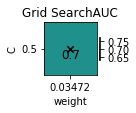

In [441]:
plot_meta_2d(meta = i_meta2, first_dimention = 'C', second_dimention = 'weight', b_best = 'AUC')

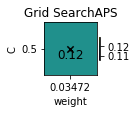

In [442]:
plot_meta_2d(meta = i_meta2, first_dimention = 'C', second_dimention = 'weight', b_best = 'APS')

In [443]:
i_meta2.to_csv(PATH +'Modeling_' + modeling + '/meta_file_after_pvalue.csv', sep='&')

In [444]:
i_meta2 = pd.read_csv(PATH +'Modeling_' + modeling + '/meta_file_after_pvalue.csv', sep='&')

In [445]:
train3 = train2.copy()
test3 = test2.copy()
list_of_columns_no_sys3 = list_of_columns_no_sys.copy()

for i in list_of_columns_no_sys:
    if i not in train3.columns.to_list():
        list_of_columns_no_sys3.remove(i)

attribute_list_model = attributes_list_new(train3, list_of_columns_no_sys3, [1, 98, 99, 99.99])

non_outliers = attribute_list_model.loc[attribute_list_model['99%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
cols_outliers = list_of_columns_no_sys.copy()
    
for o in non_outliers:
    if o in cols_outliers:
        cols_outliers.remove(o)
        
attribute_list_model['right_border'] = attribute_list_model['99%']
attribute_list_model['left_border'] = attribute_list_model['1%']
attribute_list_model.loc[attribute_list_model['attribute'].isin(non_outliers), 
                         'right_border'] = attribute_list_model['99.99%']

attribute_list_model.to_csv(PATH+'Modeling_' + modeling + '/attribute_list_model_after_pvalue2.csv')

[0.01   0.98   0.99   0.9999]
Number of finished repetitions: 0 | time:  26.06.2020 10:34:51


In [446]:
oot1 = oot[list(train3.columns)]

In [447]:
X_1_22, X_2_22, y_1_2, y_2, preproc2 = data_preprocessing(train3,
                                                          y_train, 
                                                        test3, 
                                                          y_test, necessary_fields_upper, 
                                                       categorial_list = list_of_categories_sel,
                                                 yeo_johnson = False, attribute_list = attribute_list_model, 
                                                       var_col = 'attribute',
                                                       scale = 'mean', median = 'val_mediana', check_percentile = 5,
                                                   high_outlier = 'right_border', low_outlier = 'left_border', 
                                                       cols_outlier = cols_outliers, 
                                             cut_non_out_9999 = True)

X_3_2 = data_preprocessing_test(oot1, y_oot, necessary_fields_upper, categorial_list = list_of_categories_sel, 
                                drop_technical = True,
                            attribute_list = attribute_list_model, var_col = 'attribute',
                        median = 'val_mediana',
                      high_outlier = 'right_border', low_outlier = 'left_border', scale = preproc2, 
                                yeo_johnson = None, cols_outlier = cols_outliers)

In [448]:
X_1_22.shape

(506050, 47)

In [449]:
params_dict = {'weight_0':'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear' }
pass_model = LogisticRegression

In [450]:
print(50*'-', 'By AUC test', 50*'-')
auc_model, auc_scores, auc_test_pred = train_model_receive_stats(X_1_22, 
                                                                 y_1_2, X_2_22, y_2, 
                                                                 meta = i_meta2, by_var = 'AUC',
                                                                 params_dict =params_dict, 
                                                                 other_hyperparams = other_hyps, pass_model= pass_model, 
                                                                 need_business = False, 
                                                                 simple_b_score = None,
                                                                 business_dict = None, printed =True,
                                                                 task = 'binary')


print(50*'-', 'By AUC oot', 50*'-')
auc_model, auc_scores_oot, auc_oot_pred = train_model_receive_stats(X_1_22, y_1_2, X_3_2, y_oot, 
                                                                 meta = i_meta2, by_var = 'AUC',
                                                                 params_dict =params_dict, 
                                                                 other_hyperparams = other_hyps, pass_model= pass_model, 
                                                                 need_business = False, 
                                                                 simple_b_score = None,
                                                                 business_dict = None, printed =True,
                                                                 task = 'binary')

-------------------------------------------------- By AUC test --------------------------------------------------
{'class_weight': {0: 0.03471583268454951, 1: 1}, 'C': 0.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
26.06.2020 10:36:31 start of logit fit
26.06.2020 10:37:00 end of logit fit


C:\Users\dkotereva\Filter_and_Grid_Search.py:4558: RuntimeWarning: invalid value encountered in true_divide
  f_score = (2*p_f_score*r_f_score)/(p_f_score+r_f_score)


26.06.2020 10:37:01
-------------------- Statistics --------------------
Brier score =  0.304078560412407
--------------------
AUC =  0.7016633346772461
AUC train = 0.7062751014421533
Gini =  0.40332666935449213
Gini train = 0.41255020288430666
Stability = 0.9776426396949291
Average precision score =  0.08082561892416032
---------- Treshold by F_score ----------
Accuracy =  0.8685246513363496
Score F1 =  0.13661285876190768
Precision =  0.08775727047341703
Recall =  0.3081813156440022
Approval rate =  0.11852698353467979
-------------------------------------------------- By AUC oot --------------------------------------------------
{'class_weight': {0: 0.03471583268454951, 1: 1}, 'C': 0.5, 'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear'}
26.06.2020 10:37:07 start of logit fit
26.06.2020 10:37:36 end of logit fit


C:\Users\dkotereva\Filter_and_Grid_Search.py:4558: RuntimeWarning: invalid value encountered in true_divide
  f_score = (2*p_f_score*r_f_score)/(p_f_score+r_f_score)


26.06.2020 10:37:36
-------------------- Statistics --------------------
Brier score =  0.31097097478623187
--------------------
AUC =  0.6943323013660411
AUC train = 0.7062751014421533
Gini =  0.38866460273208214
Gini train = 0.41255020288430666
Stability = 0.9421025611301835
Average precision score =  0.07531372998689244
---------- Treshold by F_score ----------
Accuracy =  0.8522057652492435
Score F1 =  0.1338311315336014
Precision =  0.08464263009717556
Recall =  0.31950634213232776
Approval rate =  0.13489409141583056


In [451]:
joblib.dump(auc_model, PATH+ 'Modeling_' + modeling + '/auc_model2.dat')
joblib.dump(preproc2, PATH+ 'Modeling_' + modeling + '/preproc2.dat')

['D:/Share/dkotereva/APP_PD_GP/Modeling_forward/preproc2.dat']

In [452]:
auc_tests = pd.DataFrame(auc_test_pred)
auc_tests.rename(columns = {0: 'prediction'}, inplace = True)

Text(0.5, 1.0, 'Histograms 0 class')

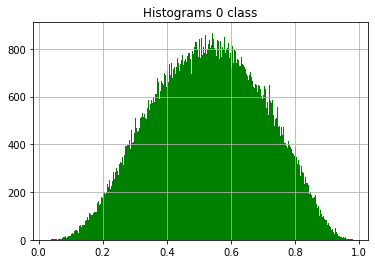

In [453]:
auc_tests.loc[y_2 == 0, 'prediction'].hist(bins = 500, color = 'green')
plt.title('Histograms 0 class')

Text(0.5, 1.0, 'Histograms 1 class')

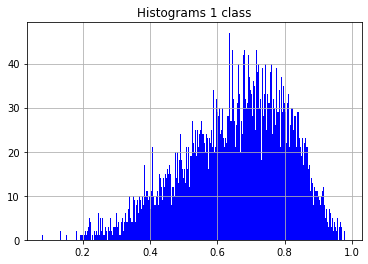

In [454]:
auc_tests.loc[y_2 == 1, 'prediction'].hist(bins = 500, color = 'blue')
plt.title('Histograms 1 class')

In [457]:
betas = []

for i, v in enumerate(X_1_22.columns):
    betas.append([v, auc_model.coef_[0][i]])
    
betas.append(['Intercept', auc_model.intercept_[0]])

betas = pd.DataFrame.from_records(betas, columns = ['Variable', 'Coef'])
definition_2 = pd.read_csv(PATH + 'SandBox/csv/definition_2.csv') 
#definition_2['variable'] = [i.upper() for i in definition_2['variable']]
betas1 = pd.merge(betas, definition_2.rename(columns = {'variable': 'Variable'}), how = 'left', on = 'Variable')
betas1['abs_coef'] = abs(betas1['Coef'])
betas1.sort_values(by = 'abs_coef', ascending = False)
betas1.to_csv(PATH +'Modeling_' + modeling + '/betas3.csv', sep='&')
betas.to_csv(PATH +'Modeling_' + modeling + '/betas_new3.csv', sep='&')

In [458]:
for_del = ['ScoreF1_b_best', 'Acc_b_best', 'Pre_b_best', 'Rec_b_best', 
               'Approval_rate_b_best', 'b_best']
for i in for_del:
    if i in auc_scores.keys():
        auc_scores.pop(i, None)
        
scores = pd.DataFrame(auc_scores)
scores.to_csv(PATH +'Modeling_' + modeling + '/scores_test.csv', sep='&')

for i in for_del:
    if i in auc_scores_oot.keys():
        auc_scores_oot.pop(i, None)
        
scores_oot = pd.DataFrame(auc_scores_oot)
scores_oot.to_csv(PATH +'Modeling_' + modeling + '/scores_oot.csv', sep='&')

In [459]:
oot2 = oot.join(y_oot)
oot2 = oot2.join(pd.Series(auc_oot_pred, name='score'))
oot2.to_csv(PATH +'Modeling_' + modeling + '/oot_with_scores.csv', sep='&')

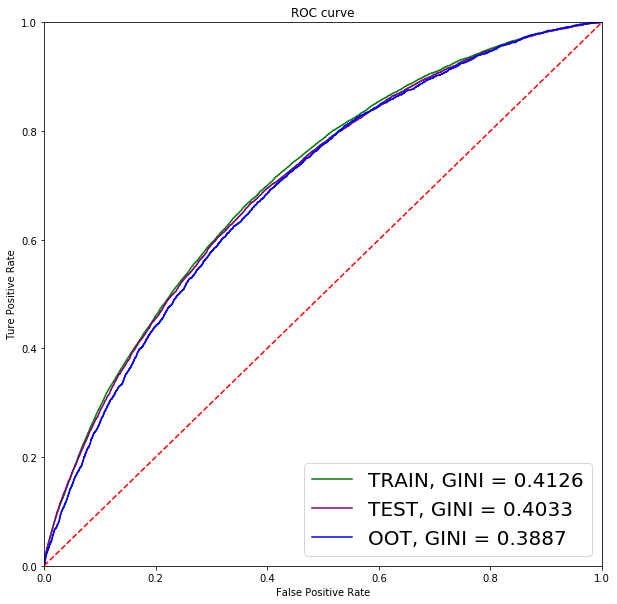

In [460]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

clf = auc_model

y_pred_train = clf.predict_proba(X_1_22)[:,1]
#train_loss = log_loss(y_1_r, y_pred_train)
y_pred_test = clf.predict_proba(X_2_22)[:,1]
y_pred_oot = clf.predict_proba(X_3_2)[:,1]

fpr_train, tpr_train, _ = metrics.roc_curve(y_1_2, y_pred_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_2, y_pred_test)
fpr_oot, tpr_oot, _ = metrics.roc_curve(y_oot, y_pred_oot)
gini_train = 2 * metrics.auc(fpr_train,tpr_train) - 1
gini_test = 2 * metrics.auc(fpr_test,tpr_test) - 1
gini_oot = 2 * metrics.auc(fpr_oot,tpr_oot) - 1

plt.figure(figsize = (10, 10))

plt.title('ROC curve')

plt.plot(fpr_train, tpr_train, label = 'TRAIN, GINI = %0.4f'%gini_train, color = 'green')
plt.plot(fpr_test, tpr_test, label = 'TEST, GINI = %0.4f'%gini_test, color = 'purple')
plt.plot(fpr_oot, tpr_oot, label = 'OOT, GINI = %0.4f'%gini_oot, color = 'blue')

plt.legend(loc = 'lower right', fontsize=20)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ture Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()## По месяцам

### Lightgbm

In [466]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

oot_gbm = oot[list(train1.columns)]

In [467]:
train_lgbm_data, test_lgbm_data, y_1_2, y_2 = data_preprocessing(train1,
                                                          y_train, 
                                                        test, 
                                                          y_test, necessary_fields_upper, 
                                                       categorial_list = list_of_categories_sel,
                                                 yeo_johnson = False, attribute_list = None, 
                                                       var_col = None,
                                                       scale = False, median = 'median', check_percentile = 5,
                                                   high_outlier = None, low_outlier = None, 
                                                       cols_outlier = [], 
                                             cut_non_out_9999 = False)

train_lgbm_data, oot_lgbm_data, y_1_2, y_3 = data_preprocessing(train1,
                                                          y_train, 
                                                        oot_gbm, 
                                                          y_oot, necessary_fields_upper, 
                                                       categorial_list = list_of_categories_sel,
                                                 yeo_johnson = False, attribute_list = None, 
                                                       var_col = None,
                                                       scale = False, median = 'median', check_percentile = 5,
                                                   high_outlier = None, low_outlier = None, 
                                                       cols_outlier = [], 
                                             cut_non_out_9999 = False)

In [468]:
params_lgbm = {
    'boosting_type': 'gbdt',
    'max_depth': 3,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'verbose': 0,
    'n_estimators': 100,
    'class_weight': {0: w_b, 1: 1},
    'random_state': 241, 
    'n_jobs': 5}

In [469]:
lightgbm_class = LGBMClassifier(**params_lgbm)
from datetime import datetime
print('Starting training...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))
# train
gbm = lightgbm_class.fit(train_lgbm_data, y_1_2)
print('Ending training...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))

y_train_pred = gbm.predict_proba(train_lgbm_data)[:, 1]
y_test_pred = gbm.predict_proba(test_lgbm_data)[:, 1]
y_oot_pred = gbm.predict_proba(oot_lgbm_data)[:, 1]

print('gini train = ', roc_auc_score(y_1_2, y_train_pred)*2-1, 
      'average precision score train = ', average_precision_score(y_train, y_train_pred))

print('gini test = ', roc_auc_score(y_2, y_test_pred)*2-1, 
      'average precision score test = ', average_precision_score(y_test, y_test_pred))

print('gini oot = ', roc_auc_score(y_3, y_oot_pred)*2-1, 
      'average precision score oot = ', average_precision_score(y_oot, y_oot_pred))

Starting training... 26.06.2020 10:38:25
Ending training... 26.06.2020 10:38:31
gini train =  0.46729665332875037 average precision score train =  0.14350813858085118
gini test =  0.4301861883564744 average precision score test =  0.08998931611370217
gini oot =  0.4184650483562353 average precision score oot =  0.08323903441869226


In [470]:
scores_lightgbm = pd.DataFrame()

scores_lightgbm['gini_train'] = [roc_auc_score(y_1_2, y_train_pred)*2-1]
scores_lightgbm['gini_test'] = [roc_auc_score(y_2, y_test_pred)*2-1]
scores_lightgbm['gini_oot'] = [roc_auc_score(y_3, y_oot_pred)*2-1]
scores_lightgbm['APS_train'] = [average_precision_score(y_train, y_train_pred)]
scores_lightgbm['APS_test'] = [average_precision_score(y_test, y_test_pred)]
scores_lightgbm['APS_oot'] = [average_precision_score(y_oot, y_oot_pred)]

In [471]:
scores_lightgbm

,gini_train,gini_test,gini_oot,APS_train,APS_test,APS_oot
0,0.467297,0.430186,0.418465,0.143508,0.089989,0.083239


In [472]:
scores_lightgbm.to_csv(PATH+ 'Modeling_' + modeling + '/scores_lightgbm.csv', sep='&')

## 2.2 Forward Scheme 

In [14]:
all_columns = pd.read_csv(PATH + 'SandBox/csv/selected_features_forest_definition.csv', sep = '&')

In [15]:
data1 = pd.read_csv(PATH + 'Data Sets/' +  train_data, sep = '\t', encoding = 'cp1251')
data1.columns = [col.upper() for col in data1.columns]

In [16]:
data = turn_variables_with_values(data1, all_columns)

In [17]:
columns = data.columns

In [18]:
changes = pd.read_csv(PATH + 'SandBox/csv/changes.csv', sep = '\t')

In [19]:
categorial_columns = []
for i in columns:
    if len(re.findall('_bin', i)) > 0:
        categorial_columns.append(i)

In [20]:
necessary_fields_upper

['BAD_90P', 'DATE_REPORT', 'CIF_ID']

In [21]:
gc.collect()

107

In [22]:
columns = list(data.columns)

In [23]:
file_name = PATH + 'Selection/excel/12. COR_NUM_binned.xlsx'
correlation_num1 = pd.read_excel(file_name)
file_name = PATH + 'Selection/excel/12. COR_CAT_binned.xlsx'
correlation_cat1 = pd.read_excel(file_name)
definition_2 = pd.read_csv(PATH + 'SandBox/csv/definition_2.csv')

In [24]:
correlation_cat1.set_index('Unnamed: 0', inplace = True)
correlation_num1.set_index('Unnamed: 0', inplace = True)

In [25]:
correlation_num1.head()

,COUNTPREVCONTR_0PL,FINALAPPROVE_FLAG_2D,R_CNT_ALL_IL,R_CNT_OPEN_GP,R_CNT_OPEN_IL,R_CNT_OPEN_CC,R_AMT_OPEN_IL,R_AMT_OPEN_CC,R_AMT_CLOS_IL,R_DLQ_SUM_30PL,...,OW_AV_DEBT_24M,INQ_MORTGAGE,INQ_CC,INQ_MORT_TTL,INQ_CC_TTL,INQ_TTL_LAST7,BURAPPRRT_L3M,AMTSEQACTV_SUM,CNTRACTVNOWN_CNT,LIMIT01_SUM
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
COUNTPREVCONTR_0PL,1.000000,0.778406,0.360325,0.458044,0.067920,0.462343,0.037179,0.313585,0.275256,0.084957,...,0.051155,-0.011665,0.074904,-0.009006,0.055388,-0.162621,0.018086,-0.007344,-0.003274,-0.003657
FINALAPPROVE_FLAG_2D,0.778406,1.000000,0.217642,0.380531,-0.031627,0.361987,0.009760,0.192429,0.204321,0.049007,...,0.072650,0.003302,0.133619,0.002544,0.104152,-0.106973,-0.001123,0.000256,0.047137,0.004767
R_CNT_ALL_IL,0.360325,0.217642,1.000000,-0.158876,0.342720,-0.066613,0.126854,-0.037425,0.442696,0.088934,...,-0.022112,0.003620,-0.050084,0.003105,-0.037790,0.013831,0.018957,0.010285,-0.013187,-0.001338
R_CNT_OPEN_GP,0.458044,0.380531,-0.158876,1.000000,-0.165679,0.387127,-0.038811,0.218372,0.043266,-0.003030,...,0.028121,-0.036887,0.030334,-0.031183,0.013625,-0.164297,-0.011375,-0.023719,-0.053885,-0.017816
R_CNT_OPEN_IL,0.067920,-0.031627,0.342720,-0.165679,1.000000,-0.087653,0.318817,-0.054988,0.005543,-0.019738,...,-0.053000,-0.022284,-0.040107,-0.017054,-0.026936,-0.083356,0.037112,-0.003219,-0.088758,-0.010027


In [26]:
result_tab_cat1, non_doubles_cat1, col_doubles_cat1, double_dic_cat1 = find_doubles_corr(data, columns, 
                                  correlation_cat1, definition = definition_2, lvl = 0.70, light_unstable = None)
result_tab_num1, non_doubles_num1, col_doubles_num1, double_dic_num1 = find_doubles_corr(data, columns, 
                                  correlation_num1, definition = definition_2, lvl = 0.70, light_unstable = None)

Порог = 0.7 Осталось фичей = 25 Коррелир.фичей = 53
Порог = 0.7 Осталось фичей = 88 Коррелир.фичей = 52


In [27]:
result_tab_cat1, non_doubles_cat1, col_doubles_cat1, double_dic_cat1 = find_doubles_corr(data, columns, 
                                  correlation_cat1, definition = definition_2, lvl = 0.50, light_unstable = None)
result_tab_num1, non_doubles_num1, col_doubles_num1, double_dic_num1 = find_doubles_corr(data, columns, 
                                  correlation_num1, definition = definition_2, lvl = 0.50, light_unstable = None)

Порог = 0.5 Осталось фичей = 17 Коррелир.фичей = 61
Порог = 0.5 Осталось фичей = 52 Коррелир.фичей = 88


In [28]:
non_doubles1 = list(set(non_doubles_cat1 + non_doubles_num1))

In [29]:
len(non_doubles1)

69

In [30]:
COL_DEL1 = []

for i in data.columns:
    if i not in non_doubles1 + necessary_fields_upper:
        COL_DEL1.append(i)

In [31]:
data.drop(COL_DEL1, axis = 1, inplace = True)

In [32]:
for i in necessary_fields_upper:
    if i not in list(data.columns):
        print(i)

In [33]:
data_prepr, scale = data_preprocessing_train(data, COL_TRG, 
                                technical_values = [COL_SYS+necessary_fields_upper], 
                                drop_technical = False,
                                yeo_johnson = False, 
                                attribute_list = None, 
                                var_col = None,
                                scale = 'mean', 
                                median = 'median',
                                high_outlier = 99, 
                                low_outlier = 1, 
                                cols_outlier = None)

data = data_preprocessing_train(data, COL_TRG, 
                                technical_values = [COL_SYS+necessary_fields_upper], 
                                drop_technical = False,
                                yeo_johnson = False, 
                                attribute_list = None, 
                                var_col = None,
                                scale = False, 
                                median = 'median',
                                high_outlier = None, 
                                low_outlier = None, 
                                cols_outlier = None)


In [34]:
if 'Unnamed: 0' in data_prepr.columns.to_list():
    data_prepr.drop('Unnamed: 0', axis = 1, inplace = True)
    
if 'Unnamed: 0.1' in data_prepr.columns.to_list():
    data_prepr.drop('Unnamed: 0.1', axis = 1, inplace = True)

In [35]:
data_prepr.head()

,CIF_ID,FINALAPPROVE_FLAG_2D,R_CNT_ALL_IL,R_CNT_OPEN_GP,R_CNT_OPEN_IL,R_CNT_OPEN_CC,R_AMT_OPEN_IL,R_AMT_CLOS_IL,R_DLQ_SUM_30PL,R_DLQ_WSTEV_MIN,...,TIME_SINCEL_90_bin,MICRO2ALL_03M_bin,LIMIT_24_MAX_bin,OPENLYEARCCSUM_bin,SINCELSTCLSDCC_bin,CLOSED24_SUM_bin,BURAPPRRT_L3M_bin,AMTSEQACTV_SUM_bin,LIMIT01_SUM_bin,BAD_90P
0,-0.023096,0.605588,0.024223,-0.562779,-0.466264,0.808351,-0.116134,-0.879727,-0.161159,-0.191623,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1
1,-0.385205,-0.424260,-1.341847,-0.562779,-0.466264,-0.493136,-0.116134,-0.187447,-0.161159,0.088510,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.519601,-1.110826,0.024223,-0.562779,-0.466264,-0.493136,-0.116134,-0.187447,-0.161159,-0.191623,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,0.109674,0.262305,1.390294,-0.562779,-0.466264,-0.493136,-0.116134,-0.257195,-0.161159,-0.191623,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1
4,0.392982,-0.424260,0.024223,-0.562779,1.864696,-0.493136,-0.110919,-0.187447,-0.161159,-0.191623,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0


In [36]:
target = target.upper()

In [37]:
X_1_2, X_2_2, y_1, y_2 = stratified_split(data_prepr, target, list_of_vars_for_strat_upper, sort_by_var_upper, 
                                      size_of_test = 0.5, drop_technical = True, random_state = 241)

In [38]:
X_1_2.shape, X_1_2.dropna().shape

((248771, 69), (248771, 69))

In [39]:
once_rows = sum(data[target])
second_rows = (len(data[target]) - sum(data[target]))
y_unique = sorted(data[target].unique())
all_rows = len(data[target])

once_rows_share = once_rows/all_rows
second_rows_share = second_rows/all_rows
second_rows_share/once_rows_share

if once_rows < second_rows:
    w_b = once_rows/second_rows
else:
    w_b = second_rows/once_rows

In [40]:
once_rows_share, second_rows_share

(0.0335510790382708, 0.9664489209617292)

In [41]:
w_b

0.03471583268454951

In [42]:
print(30*'-', 'LogisticRegression', 30*'-')

logit_params = {'class_weight': {0: 2*w_b, 1:1}}
print(20*'-', 'First sample', 20*'-')

tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
print (20*'-', 'time: ' , tm, 20*'-')

first_logit_res = calculate_metrics_for_several_vars(X_1_2, y_1, X_2_2, y_2, list(X_1_2.columns), 
                                                     LogisticRegression, logit_params,
                                                     use_metrics = [metrics.roc_auc_score,
                                                                   metrics.average_precision_score],
                                                    names = ['roc_auc_score', 'average_precision_score'], 
                                                    task = 'binary', 
                                                     integral_metrics = [metrics.roc_auc_score,
                                                                         metrics.average_precision_score],
                                                    n_jobs = 3)

print(20*'-', 'Second sample', 20*'-')

tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
print (20*'-', 'time: ' , tm, 20*'-')

sec_logit_res = calculate_metrics_for_several_vars(X_2_2, y_2, X_1_2, y_1, list(X_2_2.columns), 
                                                     LogisticRegression, logit_params,
                                                     use_metrics = [metrics.roc_auc_score,
                                                                   metrics.average_precision_score],
                                                    names = ['roc_auc_score', 'average_precision_score'], 
                                                    task = 'binary', 
                                                     integral_metrics = [metrics.roc_auc_score,
                                                                         metrics.average_precision_score],
                                                    n_jobs = 3)

print(30*'-', 'DecisionTreeClassifier', 30*'-')

tree_params = {'class_weight': {0: 2*w_b, 1:1}, 'max_depth': 4}

print(20*'-', 'First sample', 20*'-')
tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
print (20*'-', 'time: ' , tm, 20*'-')

first_tree_res = calculate_metrics_for_several_vars(X_1_2, y_1, X_2_2, y_2, list(X_1_2.columns), 
                                                     DecisionTreeClassifier, tree_params,
                                                     use_metrics = [metrics.roc_auc_score,
                                                                   metrics.average_precision_score],
                                                    names = ['roc_auc_score', 'average_precision_score'], 
                                                    task = 'binary', 
                                                     integral_metrics = [metrics.roc_auc_score,
                                                                         metrics.average_precision_score],
                                                    n_jobs = 3)


print(20*'-', 'Second sample', 20*'-')
tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
print (20*'-', 'time: ' , tm, 20*'-')

sec_tree_res = calculate_metrics_for_several_vars(X_2_2, y_2, X_1_2, y_1, list(X_2_2.columns), 
                                                     DecisionTreeClassifier, tree_params,
                                                     use_metrics = [metrics.roc_auc_score,
                                                                   metrics.average_precision_score],
                                                    names = ['roc_auc_score', 'average_precision_score'], 
                                                    task = 'binary', 
                                                     integral_metrics = [metrics.roc_auc_score,
                                                                         metrics.average_precision_score],
                                                    n_jobs = 3)

------------------------------ LogisticRegression ------------------------------
-------------------- First sample --------------------
-------------------- time:  13.07.2020 19:06:09 --------------------
-------------------- Second sample --------------------
-------------------- time:  13.07.2020 19:06:32 --------------------
------------------------------ DecisionTreeClassifier ------------------------------
-------------------- First sample --------------------
-------------------- time:  13.07.2020 19:06:52 --------------------
-------------------- Second sample --------------------
-------------------- time:  13.07.2020 19:07:09 --------------------


In [43]:
first_logit_res1 = first_logit_res.pivot(index='Feature',columns='metric')['score']
sec_logit_res1 = sec_tree_res.pivot(index='Feature',columns='metric')['score']
first_logit_res1.reset_index(inplace = True)
sec_logit_res1.reset_index(inplace = True)

first_tree_res1 = first_tree_res.pivot(index='Feature',columns='metric')['score']
sec_tree_res1 = sec_tree_res.pivot(index='Feature',columns='metric')['score']
first_tree_res1.reset_index(inplace = True)
sec_tree_res1.reset_index(inplace = True)

In [44]:
logit_all = pd.merge(first_logit_res1, sec_logit_res1, on = 'Feature', suffixes=('_1', '_2'))
tree_all = pd.merge(first_tree_res1, sec_tree_res1, on = 'Feature', suffixes=('_1', '_2'))

In [45]:
tree_all = pd.merge(first_tree_res1, sec_tree_res1, on = 'Feature', suffixes=('_1', '_2'))

In [46]:
metr = ['Gini_score', 'average_precision_score']
for i in metr:
    logit_all[i] = (logit_all[i+'_1']+logit_all[i+'_2'])/2
    tree_all[i] = (tree_all[i+'_1']+tree_all[i+'_2'])/2

In [47]:
logit_all.sort_values(by = 'Gini_score', 
                                    ascending = False, inplace = True)

In [48]:
one_factor = logit_all['Feature'].to_list()

In [49]:
len(one_factor)

69

In [50]:
vif_del = []

In [ ]:
vif = calculate_vif(data_prepr[one_factor])
vif.sort_values(by = 'VIF', ascending = False, inplace = True)

13.07.2020 19:07:29 0 FINALAPPROVE_FLAG_2D
13.07.2020 19:46:02 10 DLQ_WRSTARR24


In [ ]:
vif.head()

In [ ]:
vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()
while vif['VIF'][0] > 10:
    print(vif.head(5))
    c = vif.Features[0]
    vif_del.append(c)
    print('Delete ', c)
    vif = calculate_vif(data_prepr[[c for c in one_factor if c not in vif_del]])
    vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()

In [ ]:
vif.head()

In [ ]:
len(vif_del)

In [ ]:
new_features_list = []
cols = ['new variable', 'genuine variable', 'rule', 'values']

for i in one_factor:
    if i in list(changes['new variable']):
        change = changes[changes['new variable'] == i]
        new_features_list.append([list(change['new variable'])[0], list(change['genuine variable'])[0], 
                                  list(change['rule'])[0], list(change['values'])[0]])
    else:
        new_features_list.append([i, i, 'Missing', np.nan])
        
for i in necessary_fields_upper:
    new_features_list.append([i, i, 'Missing', np.nan])
    
new_features_data = pd.DataFrame.from_records(new_features_list, columns = cols)
new_features_data_no_vif = new_features_data[~new_features_data['new variable'].isin(vif_del)]
new_features_data_no_vif_no_sys = new_features_data_no_vif[~new_features_data_no_vif['new variable'].isin(necessary_fields_upper)]

In [ ]:
new_features_data.shape, new_features_data_no_vif.shape

In [ ]:
new_features_data.to_csv(PATH + 'SandBox/csv/selected_features_one_factor.csv', sep = '&')
new_features_data_no_vif.to_csv(PATH + 'SandBox/csv/selected_features_one_factor_vif.csv', sep = '&')
new_features_data_no_vif_no_sys.to_csv(PATH + 'SandBox/csv/selected_features_one_factor_vif_no_sys.csv', sep = '&')

In [ ]:
#new_features_data = pd.read_csv(PATH + 'SandBox/csv/selected_features_one_factor.csv', sep = '&')
#new_features_data_no_vif= pd.read_csv(PATH + 'SandBox/csv/selected_features_one_factor_vif.csv', sep = '&')
#new_features_data_no_vif_no_sys= pd.read_csv(PATH + 'SandBox/csv/selected_features_one_factor_vif_no_sys.csv', sep = '&')

In [ ]:
modeling = 'one_factor'

In [ ]:
#selected_features = pd.read_csv(PATH + 'SandBox/csv/selected_features_forest_vif.csv', sep = '&')
selected_features = new_features_data_no_vif
sel_c = selected_features['genuine variable'].to_list()

In [ ]:
gc.collect()

In [ ]:
train = pd.read_csv(PATH + 'Data Sets/' +  train_data, sep = '\t', encoding = 'cp1251')
train.columns = [col.upper() for col in train.columns]

test = pd.read_csv(PATH + 'Data Sets/' +  test_data, sep = '\t', encoding = 'cp1251')
test.columns = [col.upper() for col in test.columns]

oot = pd.read_csv(PATH + 'Data Sets/' +  oot_data, sep = '\t', encoding = 'cp1251')
oot.columns = [col.upper() for col in oot.columns]

In [ ]:
train = turn_variables_with_values(train, selected_features)
test = turn_variables_with_values(test, selected_features)
oot = turn_variables_with_values(oot, selected_features)

In [ ]:
target = target.upper()

In [ ]:
y_train = train[target]
y_test = test[target]
y_oot = oot[target]

train.drop(target, axis = 1, inplace = True)
test.drop(target, axis = 1, inplace = True)
oot.drop(target, axis = 1, inplace = True)

In [ ]:
train.head()

In [ ]:
list_of_columns = selected_features['new variable'].to_list()
list_of_columns_no_sys = list_of_columns.copy()
for i in necessary_fields_upper:
    if i in list_of_columns_no_sys:
        list_of_columns_no_sys.remove(i)

In [ ]:
len(list_of_columns_no_sys)

In [ ]:
attribute_list_model = attributes_list_new(train, list_of_columns_no_sys, [0.01, 0.5, 1, 2, 5, 95, 97, 
                                                                           98, 99, 99.5, 99.99])

In [ ]:
attribute_list_model[attribute_list_model['99%'] == attribute_list_model['1%']]

In [ ]:
list_of_categories_sel = attribute_list_model.loc[(attribute_list_model['count_dist'] == 2), 'attribute'].to_list() 

In [ ]:
categorials_data_fin = pd.read_csv(PATH + 'SandBox/csv/categories_fin.csv', sep = '&')

In [ ]:
categorials_data_fin.head()

In [ ]:
for i in list_of_columns_no_sys:
    if i in categorials_data_fin['feature'].to_list():
        list_of_categories_sel.append(i)

In [ ]:
list_of_categories_sel

In [ ]:
iqr_outliers = find_ouliers_iqr(train, necessary_fields_upper, mult = 1.5, check_percentile = 1)

In [ ]:
once_rows = sum(y_train)
second_rows = (len(y_train) - sum(y_train))
y_unique = sorted(y_train.unique())
all_rows = len(y_train)

once_rows_share = once_rows/all_rows
second_rows_share = second_rows/all_rows
second_rows_share/once_rows_share

if once_rows < second_rows:
    w_b = once_rows/second_rows
else:
    w_b = second_rows/once_rows

In [ ]:
once_rows_share, second_rows_share

In [ ]:
w_b

In [ ]:
#C = np.logspace(-3,0.5,num=9)
C = [0.5]
CC  = [1]
w = np.multiply(CC, w_b)
#C = np.logspace(-3,2,1)
#w = np.logspace(-1,1,2)*w_b
print(C)
print(w_b)
print(w)

In [ ]:
params_dictionary = {'C': C,
                     'weight_0': w,
                     'regularization': 'l2', 'random_state': 241, 
                    'solver': 'liblinear', 'max_iter':  [300]}
params_to_model = {'C': 'C', 'weight_0': 'class_weight', 'regularization':'penalty', 'random_state': 'random_state',
                  'solver': 'solver', 'max_iter': 'max_iter'}
pass_model = LogisticRegression

sort_by_var = sort_by_var.upper()
list_of_vars_for_strat = ['DATE_REPORT']
second_target = None
yeo_johnson = False
n_fold = 5
simple_b_score = simple_b_score_crm
business_dictionary = {'m_s': 15900, 'k': 47, 'c': 1}


In [ ]:
high_outs = [99]
low_outs = [1]
params_preproc_grid = {'high_outlier': high_outs, 'low_outlier': low_outs}

In [ ]:
combination_preproc = list(itertools.product(*params_preproc_grid.values()))

In [ ]:
from Filter_and_Grid_Search import br_correction

In [ ]:
train = train.join(y_train)
train1 = br_correction(train, index_month.upper(), target, correct = True, random_state = 42, alpha = 0)

In [ ]:
y_train = train1[target]
train1.drop(target, axis = 1, inplace = True)

In [ ]:
attribute_list_model = attributes_list_new(train1, list_of_columns_no_sys, high_outs+low_outs)

In [ ]:
len(C)*len(CC)

In [ ]:
from Filter_and_Grid_Search import lr_test_one_simple, lr_test_all_features

In [ ]:
new_meta_with_prepr = []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]
            
    non_outliers = attribute_list_model.loc[attribute_list_model[str(dicts['high_outlier'])+'%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
    cols_outliers = list_of_columns_no_sys.copy()
    
    for o in non_outliers:
        if o in cols_outliers:
            cols_outliers.remove(o)
                
    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta = find_meta_params(train1, y_train, 
                            params_dictionary, params_to_model, pass_model, 
                            sort_by_var, list_of_vars_for_strat, n_fold, second_target, yeo_johnson, 
                            attribute_list = None, var_col = None, categorial_list = list_of_categories_sel,
                            cols_outlier = cols_outliers,
                            need_business = False, draw = False, draw_by_approval_rate = False,
                            simple_b_score = None, business_dict = None,
                            business_dict_sec = None,
                            scale = 'mean', median = 'median',
                            high_outlier = dicts['high_outlier'], 
                            low_outlier = dicts['low_outlier'], check_percentile = 1,
                            random_state = 241, task = 'binary', k_logs = 10,
                            cut_non_out_9999 = True)
    i_meta['high_outlier'] = dicts['high_outlier']
    i_meta['low_outlier'] = dicts['low_outlier']
        
    new_meta_with_prepr.append(i_meta)

In [ ]:
i_meta['weight'] = round(i_meta['weight_0'], 4)

In [ ]:
i_meta.sort_values(by = 'AUC', ascending = False)[['AUC', 'AUC_std', 'weight_0', 'C', 'high_outlier', 'low_outlier', 'Pre']]

In [ ]:
plot_meta_2d(meta = i_meta, first_dimention = 'C', second_dimention = 'weight', b_best = 'AUC')

In [ ]:
plot_meta_2d(meta = i_meta, first_dimention = 'C', second_dimention = 'weight', b_best = 'APS')

In [ ]:
i_meta.to_csv(PATH +'Modeling_' + modeling + '/meta_file1.csv', sep='&')

In [ ]:
i_meta = pd.read_csv(PATH +'Modeling_' + modeling + '/meta_file1.csv', sep='&')

In [ ]:
list_of_columns = list(train1.columns)
list_of_columns_no_sys = list_of_columns.copy()
for i in necessary_fields_upper:
    if i in list_of_columns_no_sys:
        list_of_columns_no_sys.remove(i)

In [ ]:
attribute_list_model = attributes_list_new(train, list_of_columns_no_sys, [1, 98, 99, 99.99])

In [ ]:
non_outliers = attribute_list_model.loc[attribute_list_model['99%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
cols_outliers = list_of_columns_no_sys.copy()
    
for o in non_outliers:
    if o in cols_outliers:
        cols_outliers.remove(o)

In [ ]:
non_outliers

In [ ]:
attribute_list_model['right_border'] = attribute_list_model['99%']
attribute_list_model['left_border'] = attribute_list_model['1%']

In [ ]:
attribute_list_model.loc[attribute_list_model['attribute'].isin(non_outliers), 'right_border'] = attribute_list_model['99.99%']

In [ ]:
attribute_list_model.to_csv(PATH+'Modeling_' + modeling + '/attribute_list_model_bef_pvalue.csv')

In [ ]:
oot1 = oot[train1.columns].copy()

In [ ]:
X_1_2, X_2_2, y_1_2, y_2, preproc_before_pvalue = data_preprocessing(train1, 
                                                                     y_train, 
                                                                            test, 
                                                                     y_test, necessary_fields_upper, 
                                                       categorial_list = list_of_categories_sel,
                                                 yeo_johnson = False, attribute_list = attribute_list_model, 
                                                       var_col = 'attribute',
                                                       scale = 'mean', median = 'val_mediana', check_percentile = 5,
                                                   high_outlier = 'right_border', low_outlier = 'left_border', 
                                                       cols_outlier = cols_outliers, 
                                             cut_non_out_9999 = True)

X_3_2 = data_preprocessing_test(oot1, y_oot, necessary_fields_upper, categorial_list = list_of_categories_sel, 
                                drop_technical = True,
                            attribute_list = attribute_list_model, var_col = 'attribute',
                        median = 'val_mediana',
                      high_outlier = 'right_border', low_outlier = 'left_border', scale = preproc_before_pvalue, 
                                yeo_johnson = None, cols_outlier = cols_outliers)

In [ ]:
X_1_2.shape

In [ ]:
params_dict = {'weight_0':'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear' }
pass_model = LogisticRegression

In [ ]:
X_1_2.columns

In [ ]:
print(50*'-', 'By AUC', 50*'-')
auc_model_before_pvalue, auc_scores_before_pvalue, auc_test_pred_before_pvalue = train_model_receive_stats(X_1_2, 
                                                                 y_1_2, X_2_2, y_2, 
                                                                 meta = i_meta, by_var = 'AUC',
                                                                 params_dict =params_dict, 
                                                                 other_hyperparams = other_hyps, pass_model= pass_model, 
                                                                 need_business = False, 
                                                                 simple_b_score = None,
                                                                 business_dict = None, printed =True,
                                                                 task = 'binary')

print(50*'-', 'By AUC oot', 50*'-')
auc_model_before_pvalue, auc_scores_oot_before_pvalue, auc_oot_pred_before_pvalue = train_model_receive_stats(X_1_2, y_1_2, 
                                                                                                              X_3_2, y_oot, 
                                                                 meta = i_meta, by_var = 'AUC',
                                                                 params_dict =params_dict, 
                                                                 other_hyperparams = other_hyps, pass_model= pass_model, 
                                                                 need_business = False, 
                                                                 simple_b_score = None,
                                                                 business_dict = None, printed =True,
                                                                 task = 'binary')

In [ ]:
betas_before_pvalue = []

for i, v in enumerate(X_1_2.columns):
    betas_before_pvalue.append([v, auc_model_before_pvalue.coef_[0][i]])
    
betas_before_pvalue.append(['Intercept', auc_model_before_pvalue.intercept_[0]])

betas_before_pvalue = pd.DataFrame.from_records(betas_before_pvalue, columns = ['Variable', 'Coef'])
definition_2 = pd.read_csv(PATH + 'SandBox/csv/definition_2.csv')
#definition_2['variable'] = [i.upper() for i in definition_2['variable']]
betas1_before_pvalue = pd.merge(betas_before_pvalue, definition_2.rename(columns = {'variable': 'Variable'}), 
                                how = 'left', on = 'Variable')
betas1_before_pvalue['abs_coef'] = abs(betas1_before_pvalue['Coef'])
betas1_before_pvalue.sort_values(by = 'abs_coef', ascending = False)
betas1_before_pvalue.to_csv(PATH +'Modeling_' + modeling + '/betas3_before_pvalue.csv', sep='&')
betas_before_pvalue.to_csv(PATH +'Modeling_' + modeling + '/betas_new3_before_pvalue.csv', sep='&')

In [ ]:
for_del = ['ScoreF1_b_best', 'Acc_b_best', 'Pre_b_best', 'Rec_b_best', 
               'Approval_rate_b_best', 'b_best']
for i in for_del:
    if i in auc_scores_before_pvalue.keys():
        auc_scores_before_pvalue.pop(i, None)
        
scores_before_pvalue = pd.DataFrame(auc_scores_before_pvalue)
scores_before_pvalue.to_csv(PATH +'Modeling_' + modeling + '/scores_test_before_pvalue.csv', sep='&')

for i in for_del:
    if i in auc_scores_oot_before_pvalue.keys():
        auc_scores_oot_before_pvalue.pop(i, None)
        
scores_oot_before_pvalue = pd.DataFrame(auc_scores_oot_before_pvalue)
scores_oot_before_pvalue.to_csv(PATH +'Modeling_' + modeling + '/scores_oot_before_pvalue.csv', sep='&')

In [ ]:
joblib.dump(auc_model_before_pvalue, PATH+ 'Modeling_' + modeling + '/auc_model_before_pvalue2.dat')
joblib.dump(preproc_before_pvalue, PATH+ 'Modeling_' + modeling + '/preproc_before_pvalue2.dat')

In [ ]:
from Filter_and_Grid_Search import lr_test_one_simple, lr_test_all_features

In [ ]:
p_values2 = lr_test_all_features(auc_model_before_pvalue, LogisticRegression, X_1_2, y_train, 
                                 class_weight = auc_model_before_pvalue.get_params()['class_weight'],
                                 whole_model = True)
p_values2.sort_values(by = 'p_value', ascending = False, inplace = True)

In [ ]:
#p_values2.to_csv(PATH + 'SandBox/csv/p_values2.csv', sep = '&')
p_values2.to_csv(PATH + 'Modeling_' + modeling + '/p_values2.csv', sep = '&')

In [ ]:
p_values2 = pd.read_csv(PATH + 'Modeling_' + modeling + '/p_values2.csv', sep = '&')
p_values2.sort_values(by = 'p_value', ascending = False, inplace = True)

In [ ]:
del_vars = p_values2.loc[p_values2['p_value'] > 0.05, 'Variable'].to_list()
if 'Intercept' in del_vars:
        del_vars.remove('Intercept')

In [ ]:
len(del_vars)

In [ ]:
train2 = train1.drop(del_vars, axis = 1)
test2 = test.drop(del_vars, axis = 1)

In [ ]:
list_of_columns_no_sys2 = list_of_columns_no_sys.copy()

for i in list_of_columns_no_sys:
    if i not in train2.columns.to_list():
        list_of_columns_no_sys2.remove(i)
        
attribute_list_model = attributes_list_new(train2, list_of_columns_no_sys2, high_outs+low_outs)

non_outliers = attribute_list_model.loc[attribute_list_model['99%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
cols_outliers = list_of_columns_no_sys2.copy()
    
for o in non_outliers:
    if o in cols_outliers:
        cols_outliers.remove(o)

### Final train (selection with p-value)

In [ ]:
C = [0.5]
CC  = [1]
w = np.multiply(CC, w_b)
print(C)
print(w_b)
print(w)

In [ ]:
len(C)*len(CC)

In [ ]:
params_dictionary = {'C': C,
                     'weight_0': w,
                     'regularization': 'l2', 'random_state': 241, 
                    'solver': 'liblinear', 'max_iter':  [300]}
params_to_model = {'C': 'C', 'weight_0': 'class_weight', 'regularization':'penalty', 'random_state': 'random_state',
                  'solver': 'solver', 'max_iter': 'max_iter'}
pass_model = LogisticRegression

sort_by_var = sort_by_var.upper()
list_of_vars_for_strat = ['DATE_REPORT']
second_target = None
yeo_johnson = False
n_fold = 5
simple_b_score = simple_b_score_crm
business_dictionary = {'m_s': 15900, 'k': 47, 'c': 1}
high_outs = [99]
low_outs = [1]
params_preproc_grid = {'high_outlier': high_outs, 'low_outlier': low_outs}
combination_preproc = list(itertools.product(*params_preproc_grid.values()))

In [ ]:
new_meta_with_prepr2 = []

for combination in combination_preproc:
    outputs = list(combination)
    dicts = {}
    for position in range(len(combination)):
        dicts[list(params_preproc_grid.keys())[position]] = combination[position]
            
    non_outliers = attribute_list_model.loc[attribute_list_model[str(dicts['high_outlier'])+'%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
    cols_outliers = list_of_columns_no_sys.copy()
    
    for o in non_outliers:
        if o in cols_outliers:
            cols_outliers.remove(o)
                
    print('-'*20, dicts, non_outliers, '-'*20)
    i_meta2 = find_meta_params(train2, y_train, 
                            params_dictionary, params_to_model, pass_model, 
                            sort_by_var, list_of_vars_for_strat, n_fold, second_target, yeo_johnson, 
                            attribute_list = None, var_col = None, categorial_list = list_of_categories_sel,
                            cols_outlier = cols_outliers,
                            need_business = False, draw = False, draw_by_approval_rate = False,
                            simple_b_score = simple_b_score, business_dict = business_dictionary,
                            business_dict_sec = None,
                            scale = 'mean', median = 'median',
                            high_outlier = dicts['high_outlier'], 
                            low_outlier = dicts['low_outlier'], check_percentile = 1,
                            random_state = 241, task = 'binary', k_logs = 10,
                            cut_non_out_9999 = True)
    i_meta2['high_outlier'] = dicts['high_outlier']
    i_meta2['low_outlier'] = dicts['low_outlier']
        
    new_meta_with_prepr2.append(i_meta2)

In [ ]:
i_meta2['weight'] = round(i_meta2['weight_0'], 5)

In [ ]:
plot_meta_2d(meta = i_meta2, first_dimention = 'C', second_dimention = 'weight', b_best = 'AUC')

In [ ]:
plot_meta_2d(meta = i_meta2, first_dimention = 'C', second_dimention = 'weight', b_best = 'APS')

In [ ]:
i_meta2.to_csv(PATH +'Modeling_' + modeling + '/meta_file_after_pvalue.csv', sep='&')

In [ ]:
i_meta2 = pd.read_csv(PATH +'Modeling_' + modeling + '/meta_file_after_pvalue.csv', sep='&')

In [ ]:
train3 = train2.copy()
test3 = test2.copy()
list_of_columns_no_sys3 = list_of_columns_no_sys.copy()

for i in list_of_columns_no_sys:
    if i not in train3.columns.to_list():
        list_of_columns_no_sys3.remove(i)

attribute_list_model = attributes_list_new(train3, list_of_columns_no_sys3, [1, 98, 99, 99.99])

non_outliers = attribute_list_model.loc[attribute_list_model['99%'] == attribute_list_model['1%'], 
                                                'attribute'].to_list()
cols_outliers = list_of_columns_no_sys.copy()
    
for o in non_outliers:
    if o in cols_outliers:
        cols_outliers.remove(o)
        
attribute_list_model['right_border'] = attribute_list_model['99%']
attribute_list_model['left_border'] = attribute_list_model['1%']
attribute_list_model.loc[attribute_list_model['attribute'].isin(non_outliers), 
                         'right_border'] = attribute_list_model['99.99%']

attribute_list_model.to_csv(PATH+'Modeling_' + modeling + '/attribute_list_model_after_pvalue2.csv')

In [ ]:
oot1 = oot[list(train3.columns)]

In [ ]:
X_1_22, X_2_22, y_1_2, y_2, preproc2 = data_preprocessing(train3,
                                                          y_train, 
                                                        test3, 
                                                          y_test, necessary_fields_upper, 
                                                       categorial_list = list_of_categories_sel,
                                                 yeo_johnson = False, attribute_list = attribute_list_model, 
                                                       var_col = 'attribute',
                                                       scale = 'mean', median = 'val_mediana', check_percentile = 5,
                                                   high_outlier = 'right_border', low_outlier = 'left_border', 
                                                       cols_outlier = cols_outliers, 
                                             cut_non_out_9999 = True)

X_3_2 = data_preprocessing_test(oot1, y_oot, necessary_fields_upper, categorial_list = list_of_categories_sel, 
                                drop_technical = True,
                            attribute_list = attribute_list_model, var_col = 'attribute',
                        median = 'val_mediana',
                      high_outlier = 'right_border', low_outlier = 'left_border', scale = preproc2, 
                                yeo_johnson = None, cols_outlier = cols_outliers)

In [ ]:
X_1_22.shape

In [ ]:
params_dict = {'weight_0':'class_weight', 'C': 'C', 'max_iter': 'max_iter'}
other_hyps = {'max_iter': 300, 'penalty': 'l2', 'random_state': 241, 'solver': 'liblinear' }
pass_model = LogisticRegression

In [ ]:
print(50*'-', 'By AUC test', 50*'-')
auc_model, auc_scores, auc_test_pred = train_model_receive_stats(X_1_22, 
                                                                 y_1_2, X_2_22, y_2, 
                                                                 meta = i_meta2, by_var = 'AUC',
                                                                 params_dict =params_dict, 
                                                                 other_hyperparams = other_hyps, pass_model= pass_model, 
                                                                 need_business = False, 
                                                                 simple_b_score = None,
                                                                 business_dict = None, printed =True,
                                                                 task = 'binary')


print(50*'-', 'By AUC oot', 50*'-')
auc_model, auc_scores_oot, auc_oot_pred = train_model_receive_stats(X_1_22, y_1_2, X_3_2, y_oot, 
                                                                 meta = i_meta2, by_var = 'AUC',
                                                                 params_dict =params_dict, 
                                                                 other_hyperparams = other_hyps, pass_model= pass_model, 
                                                                 need_business = False, 
                                                                 simple_b_score = None,
                                                                 business_dict = None, printed =True,
                                                                 task = 'binary')

In [ ]:
joblib.dump(auc_model, PATH+ 'Modeling_' + modeling + '/auc_model2.dat')
joblib.dump(preproc2, PATH+ 'Modeling_' + modeling + '/preproc2.dat')

In [ ]:
auc_tests = pd.DataFrame(auc_test_pred)
auc_tests.rename(columns = {0: 'prediction'}, inplace = True)

In [ ]:
auc_tests.loc[y_2 == 0, 'prediction'].hist(bins = 500, color = 'green')
plt.title('Histograms 0 class')

In [ ]:
auc_tests.loc[y_2 == 1, 'prediction'].hist(bins = 500, color = 'blue')
plt.title('Histograms 1 class')

In [ ]:
y_2.value_counts()

In [ ]:
X_1_22.shape

In [ ]:
betas = []

for i, v in enumerate(X_1_22.columns):
    betas.append([v, auc_model.coef_[0][i]])
    
betas.append(['Intercept', auc_model.intercept_[0]])

betas = pd.DataFrame.from_records(betas, columns = ['Variable', 'Coef'])
definition_2 = pd.read_csv(PATH + 'SandBox/csv/definition_2.csv')
#definition_2['variable'] = [i.upper() for i in definition_2['variable']]
betas1 = pd.merge(betas, definition_2.rename(columns = {'variable': 'Variable'}), how = 'left', on = 'Variable')
betas1['abs_coef'] = abs(betas1['Coef'])
betas1.sort_values(by = 'abs_coef', ascending = False)
betas1.to_csv(PATH +'Modeling_' + modeling + '/betas3.csv', sep='&')
betas.to_csv(PATH +'Modeling_' + modeling + '/betas_new3.csv', sep='&')

In [ ]:
for_del = ['ScoreF1_b_best', 'Acc_b_best', 'Pre_b_best', 'Rec_b_best', 
               'Approval_rate_b_best', 'b_best']
for i in for_del:
    if i in auc_scores.keys():
        auc_scores.pop(i, None)
        
scores = pd.DataFrame(auc_scores)
scores.to_csv(PATH +'Modeling_' + modeling + '/scores_test.csv', sep='&')

for i in for_del:
    if i in auc_scores_oot.keys():
        auc_scores_oot.pop(i, None)
        
scores_oot = pd.DataFrame(auc_scores_oot)
scores_oot.to_csv(PATH +'Modeling_' + modeling + '/scores_oot.csv', sep='&')

In [ ]:
oot2 = oot.join(y_oot)
oot2 = oot2.join(pd.Series(auc_oot_pred, name='score'))
oot2.to_csv(PATH +'Modeling_' + modeling + '/oot_with_scores.csv', sep='&')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

clf = auc_model

y_pred_train = clf.predict_proba(X_1_22)[:,1]
#train_loss = log_loss(y_1_r, y_pred_train)
y_pred_test = clf.predict_proba(X_2_22)[:,1]
y_pred_oot = clf.predict_proba(X_3_2)[:,1]

fpr_train, tpr_train, _ = metrics.roc_curve(y_1_2, y_pred_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_2, y_pred_test)
fpr_oot, tpr_oot, _ = metrics.roc_curve(y_oot, y_pred_oot)
gini_train = 2 * metrics.auc(fpr_train,tpr_train) - 1
gini_test = 2 * metrics.auc(fpr_test,tpr_test) - 1
gini_oot = 2 * metrics.auc(fpr_oot,tpr_oot) - 1

plt.figure(figsize = (10, 10))

plt.title('ROC curve')

plt.plot(fpr_train, tpr_train, label = 'TRAIN, GINI = %0.4f'%gini_train, color = 'green')
plt.plot(fpr_test, tpr_test, label = 'TEST, GINI = %0.4f'%gini_test, color = 'purple')
plt.plot(fpr_oot, tpr_oot, label = 'OOT, GINI = %0.4f'%gini_oot, color = 'blue')

plt.legend(loc = 'lower right', fontsize=20)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ture Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

### Lightgbm

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

oot_gbm = oot[list(train1.columns)]

In [ ]:
train_lgbm_data, test_lgbm_data, y_1_2, y_2 = data_preprocessing(train1,
                                                          y_train, 
                                                        test, 
                                                          y_test, necessary_fields_upper, 
                                                       categorial_list = list_of_categories_sel,
                                                 yeo_johnson = False, attribute_list = None, 
                                                       var_col = None,
                                                       scale = False, median = 'median', check_percentile = 5,
                                                   high_outlier = None, low_outlier = None, 
                                                       cols_outlier = [], 
                                             cut_non_out_9999 = False)

train_lgbm_data, oot_lgbm_data, y_1_2, y_3 = data_preprocessing(train1,
                                                          y_train, 
                                                        oot_gbm, 
                                                          y_oot, necessary_fields_upper, 
                                                       categorial_list = list_of_categories_sel,
                                                 yeo_johnson = False, attribute_list = None, 
                                                       var_col = None,
                                                       scale = False, median = 'median', check_percentile = 5,
                                                   high_outlier = None, low_outlier = None, 
                                                       cols_outlier = [], 
                                             cut_non_out_9999 = False)

In [ ]:
params_lgbm = {
    'boosting_type': 'gbdt',
    'max_depth': 3,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'verbose': 0,
    'n_estimators': 100,
    'class_weight': {0: w_b, 1: 1},
    'random_state': 241, 
    'n_jobs': 5}

In [ ]:
lightgbm_class = LGBMClassifier(**params_lgbm)
from datetime import datetime
print('Starting training...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))
# train
gbm = lightgbm_class.fit(train_lgbm_data, y_1_2)
print('Ending training...', datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S"))

y_train_pred = gbm.predict_proba(train_lgbm_data)[:, 1]
y_test_pred = gbm.predict_proba(test_lgbm_data)[:, 1]
y_oot_pred = gbm.predict_proba(oot_lgbm_data)[:, 1]

print('gini train = ', roc_auc_score(y_1_2, y_train_pred)*2-1, 
      'average precision score train = ', average_precision_score(y_train, y_train_pred))

print('gini test = ', roc_auc_score(y_2, y_test_pred)*2-1, 
      'average precision score test = ', average_precision_score(y_test, y_test_pred))

print('gini oot = ', roc_auc_score(y_3, y_oot_pred)*2-1, 
      'average precision score oot = ', average_precision_score(y_oot, y_oot_pred))

In [ ]:
scores_lightgbm = pd.DataFrame()

scores_lightgbm['gini_train'] = [roc_auc_score(y_1_2, y_train_pred)*2-1]
scores_lightgbm['gini_test'] = [roc_auc_score(y_2, y_test_pred)*2-1]
scores_lightgbm['gini_oot'] = [roc_auc_score(y_3, y_oot_pred)*2-1]
scores_lightgbm['APS_train'] = [average_precision_score(y_train, y_train_pred)]
scores_lightgbm['APS_test'] = [average_precision_score(y_test, y_test_pred)]
scores_lightgbm['APS_oot'] = [average_precision_score(y_oot, y_oot_pred)]

In [ ]:
scores_lightgbm

In [ ]:
scores_lightgbm.to_csv(PATH+ 'Modeling_' + modeling + '/scores_lightgbm.csv', sep='&')